In [2]:
from scipy.constants import c
import numpy as np
from numpy.lib import recfunctions as rec
from astropy.io          import fits
from astropy.coordinates import SkyCoord, Angle, search_around_sky
from astropy             import units as u
from astropy import cosmology
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from redmapper import RunZScan
from redmapper import Configuration
from matplotlib import pyplot as plt
import pandas as pd
import math
from tqdm.notebook import tqdm
import pickle
import time
import scipy.optimize as optimize
from iminuit import Minuit

import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib
from matplotlib import cm

from scipy.stats import norm
from scipy import interpolate
from sklearn.mixture import GaussianMixture

# convert all files matching a glob
import img2pdf
import glob
import re

import emcee
import corner

# Here is the plan:

* Read in catalogs--ACT, redMaPPer, and SDSS specobj. Later on, you will need the redMaPPer randoms.
* Prepare the ACT catalog for a run (optional). First, find the nearest cylindrical match in the redMaPPer catalog. Next, find the nearest specroscopic galaxy in SDSS. Append this info to the ACT catalog.
* Run the ACT catalog three times: ACT with the prior on, ACT with the prior off, and a catalog of randoms
* Append information about the optical match from runzscan to the catalog
* Save the resulting catalogs for the next step

In [4]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [77]:
def match_cat_to_zscan(catalog,zscanrun):

    #This code appends the result of runzscan to the original catalog
    #The final df then has everything in the original catalog, plus
    #the characteristics of the matched optical cluster.
    
    o = pd.DataFrame(columns = catalog.columns)
    for i in range(len(zscanrun.cat.mem_match_id)):
        o=o.append(catalog[np.isclose(catalog.nearest_ra,zscanrun.cat.nearest_ra[i]) & np.isclose(catalog.nearest_dec,zscanrun.cat.nearest_dec[i]) & np.isclose(catalog.redshift,zscanrun.cat.myz[i])])

    catalog=o

    catalog['zopt']=zscanrun.cat.z_lambda_opt
    catalog['zopt_e']=zscanrun.cat.z_lambda_opt_e
    catalog['raopt']=zscanrun.cat.ra_opt
    catalog['decopt']=zscanrun.cat.dec_opt
    catalog['lambdaopt']=zscanrun.cat.lambda_opt
    catalog['lambdaopterr']=zscanrun.cat.lambda_opt_e
    catalog['maskfrac']=zscanrun.cat.maskfrac
    catalog['z_norecenter']=zscanrun.cat.z_lambda
    catalog['lambda_norecenter']=zscanrun.cat.mylambda

    myzsteps = np.empty(len(catalog), dtype=object)
    for i in range(len(catalog)):
        myzsteps[i]=[]
        myzsteps[i].extend(zscanrun.cat[i].z_steps.tolist())
    catalog['z_steps']=myzsteps

    mylikesteps = np.empty(len(catalog), dtype=object)
    for i in range(len(catalog)):
        mylikesteps[i]=[]
        mylikesteps[i].extend(zscanrun.cat[i].likelihood_steps.tolist())
    catalog['likelihood_steps']=mylikesteps

    #Drop deep clusters
    badzopt=catalog.iloc[np.where(catalog.zopt==-1)].index
    catalog=catalog.drop(badzopt)

    badzopt=catalog.iloc[np.where((catalog.redshift>=0.55))].index
    catalog=catalog.drop(badzopt)
    badzopt=catalog.iloc[np.where((catalog.redshift<=0.1))].index
    catalog=catalog.drop(badzopt)

    #Drop masked clusters
    badmaskfrac=catalog.iloc[np.where(catalog.maskfrac>0.2)].index
    catalog=catalog.drop(badmaskfrac)

    return catalog

In [6]:
def angular_separation(ra1,dec1,ra2,dec2):
    r1=np.radians(np.array(ra1))
    d1=np.radians(np.array(dec1))
    r2=np.radians(np.array(ra2))
    d2=np.radians(np.array(dec2))
    
    angular_sep=np.arccos(np.sin(d1)*np.sin(d2)+np.cos(d1)*np.cos(d2)*np.cos(r1-r2))
    idx=np.where(np.isnan(angular_sep))[0]
    angular_sep[idx]=0
    
    return angular_sep

In [7]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-')

In [8]:
def to_ra(time_string):
    fields = time_string.split()
    hours = fields[0] if len(fields) > 0 else 0.0
    minutes = fields[1] if len(fields) > 1 else 0.0
    seconds = fields[2] if len(fields) > 2 else 0.0
    return float(hours)*15 + float(minutes)/4 + float(seconds)/240

In [9]:
def to_dec(time_string):
    fields = time_string.split()
    hours = fields[0] if len(fields) > 0 else 0.0
    minutes = fields[1] if len(fields) > 1 else 0.0
    seconds = fields[2] if len(fields) > 2 else 0.0
    return float(hours) + float(minutes)/60 + float(seconds)/3600

In [10]:
#Import the dr8 run of redmapper and the dr14 version of sdss
redmap = fits.getdata("../rozo/redmapper_dr8_public_v6.3_catalog.fits")
#cutting clusters that don't have redshift
cluster_z_filter = redmap["Z_LAMBDA"]

print("Length of clusters before cutting those without redshift:", len(redmap))
redmap = redmap[np.where(cluster_z_filter != -1)]
print("Length of clusters after cutting those without redshift:", len(redmap))
redmap=pd.DataFrame.from_records(redmap.tolist(), columns=redmap.dtype.names)

dr14 = fits.getdata("../rozo/specObj-dr14.fits")
#cutting dr14 on class
clss = dr14["CLASS"]
dr14 = dr14[np.where(clss == "GALAXY")]
print("Length of dr14 after cutting on class:", len(dr14))
#cutting data with suspicious redshifts
dr14 = dr14[np.where((dr14['ZWARNING']==16) |
                   (dr14['ZWARNING']==0) |
                   (dr14['ZWARNING']==4))]
print("Length of dr14 after cutting out suspicious redshifts:", len(dr14))

Length of clusters before cutting those without redshift: 26111
Length of clusters after cutting those without redshift: 26111
Length of dr14 after cutting on class: 2779151
Length of dr14 after cutting out suspicious redshifts: 2635685


In [18]:
ACT=Table.read('../rozo/DR5_cluster-catalog_v1.0.fits')
ACT=ACT.to_pandas()
ACT['recno']=ACT.index.values

In [19]:
ACT=ACT.drop(np.where(ACT['redshift']>0.55)[0])

In [15]:
COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(ACT.redshift).value #Mpc/radian
D_A=COSMO.angular_diameter_distance(ACT.redshift).value*np.radians(1.) #Mpc/degree
deg_err=(1.483/ACT.fixed_SNR-0.012)/60 #degree
sep=deg_err*D_A #Mpc

In [16]:
#Run to here every time

In [ ]:
###################################################################################################

# It is useful to have the index of the redmapper cluster and the spectroscopic galaxy closest to the mass signal. Here I prepare this to be appended to the catalog.
Ignore this, or treat it like a subroutine...

In [20]:
ACT_by_mass=ACT.sort_values('M500c',ascending=False).reset_index(drop=True)
redmap_by_mass=redmap.sort_values('LAMBDA',ascending=False).reset_index(drop=True)
ACT_by_mass['match']=np.zeros(len(ACT),dtype=int)
redmap_by_mass['sep']=np.zeros(len(redmap))

In [41]:
#Fraction of R_lambda allowed to be a match
Nrl=2.2
#set up some variables
COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(redmap_by_mass.Z_LAMBDA).value #Mpc
richness = redmap_by_mass.LAMBDA
r_lambda = (richness/100)**0.2
redmap_by_mass['theta_max'] = Nrl * r_lambda/ angular_diameter_distances #radians

In [22]:
count=0

for i in tqdm(range(len(ACT))):
    central_ra = np.radians(ACT_by_mass.RADeg)
    central_dec = np.radians(ACT_by_mass.decDeg)
    member_ra = np.radians(redmap_by_mass.RA)
    member_dec = np.radians(redmap_by_mass.DEC)
    sep=np.arccos(np.sin(member_dec)*math.sin(central_dec[i])+np.cos(member_dec)*math.cos(central_dec[i])*np.cos(member_ra-central_ra[i]))    
    redmap_by_mass.sep=sep
    matches=redmap_by_mass[ (redmap_by_mass.sep < redmap_by_mass.theta_max) ]['LAMBDA']
    if (len(matches)>0): 
        idx=matches.idxmax()
        print("to_match index",i)
        print("match_index",idx)
        ACT_by_mass.loc[i,'match']=idx
        redmap_by_mass=redmap_by_mass.drop(idx)
    else:
        print('dropping',i)
        ACT_by_mass=ACT_by_mass.drop(i)

  0%|          | 0/2558 [00:00<?, ?it/s]

dropping 0
to_match index 1
match_index 30
dropping 2
dropping 3
dropping 4
dropping 5
dropping 6
to_match index 7
match_index 86
to_match index 8
match_index 25
dropping 9
dropping 10
dropping 11
dropping 12
to_match index 13
match_index 0
dropping 14
dropping 15
dropping 16
to_match index 17
match_index 1378
to_match index 18
match_index 54
dropping 19
dropping 20
to_match index 21
match_index 51
dropping 22
dropping 23
dropping 24
dropping 25
dropping 26
dropping 27
dropping 28
dropping 29
to_match index 30
match_index 9
dropping 31
to_match index 32
match_index 270
dropping 33
to_match index 34
match_index 69
dropping 35
dropping 36
to_match index 37
match_index 151
to_match index 38
match_index 1
to_match index 39
match_index 426
dropping 40
dropping 41
dropping 42
dropping 43
to_match index 44
match_index 22
to_match index 45
match_index 321
to_match index 46
match_index 24
to_match index 47
match_index 18
dropping 48
dropping 49
to_match index 50
match_index 258
dropping 51
drop

dropping 417
dropping 418
dropping 419
dropping 420
to_match index 421
match_index 2229
dropping 422
dropping 423
to_match index 424
match_index 2324
dropping 425
dropping 426
to_match index 427
match_index 78
dropping 428
dropping 429
dropping 430
dropping 431
dropping 432
to_match index 433
match_index 644
dropping 434
dropping 435
dropping 436
dropping 437
dropping 438
dropping 439
to_match index 440
match_index 754
dropping 441
to_match index 442
match_index 4415
to_match index 443
match_index 4223
to_match index 444
match_index 4220
dropping 445
dropping 446
to_match index 447
match_index 1046
to_match index 448
match_index 4022
dropping 449
to_match index 450
match_index 1840
dropping 451
dropping 452
to_match index 453
match_index 4781
to_match index 454
match_index 693
to_match index 455
match_index 1182
dropping 456
to_match index 457
match_index 4011
dropping 458
dropping 459
dropping 460
dropping 461
dropping 462
dropping 463
dropping 464
dropping 465
dropping 466
dropping 4

dropping 797
to_match index 798
match_index 1741
dropping 799
dropping 800
to_match index 801
match_index 2192
to_match index 802
match_index 415
to_match index 803
match_index 1496
dropping 804
dropping 805
dropping 806
to_match index 807
match_index 449
dropping 808
to_match index 809
match_index 3903
to_match index 810
match_index 20077
to_match index 811
match_index 551
dropping 812
to_match index 813
match_index 3502
to_match index 814
match_index 8832
dropping 815
to_match index 816
match_index 16819
to_match index 817
match_index 412
dropping 818
to_match index 819
match_index 6290
to_match index 820
match_index 302
to_match index 821
match_index 742
dropping 822
to_match index 823
match_index 898
to_match index 824
match_index 1529
dropping 825
dropping 826
dropping 827
dropping 828
dropping 829
dropping 830
dropping 831
to_match index 832
match_index 1152
to_match index 833
match_index 1773
dropping 834
dropping 835
dropping 836
to_match index 837
match_index 5978
to_match ind

dropping 1184
dropping 1185
dropping 1186
dropping 1187
dropping 1188
to_match index 1189
match_index 409
to_match index 1190
match_index 7834
to_match index 1191
match_index 1260
dropping 1192
dropping 1193
to_match index 1194
match_index 8605
dropping 1195
dropping 1196
to_match index 1197
match_index 827
to_match index 1198
match_index 2884
dropping 1199
to_match index 1200
match_index 1939
to_match index 1201
match_index 1373
to_match index 1202
match_index 18015
to_match index 1203
match_index 2571
dropping 1204
to_match index 1205
match_index 4718
to_match index 1206
match_index 2953
to_match index 1207
match_index 1138
dropping 1208
dropping 1209
to_match index 1210
match_index 567
to_match index 1211
match_index 2039
dropping 1212
dropping 1213
dropping 1214
dropping 1215
dropping 1216
dropping 1217
dropping 1218
dropping 1219
dropping 1220
to_match index 1221
match_index 463
dropping 1222
to_match index 1223
match_index 7127
dropping 1224
dropping 1225
dropping 1226
to_match i

dropping 1564
to_match index 1565
match_index 7125
to_match index 1566
match_index 15596
to_match index 1567
match_index 886
to_match index 1568
match_index 1596
dropping 1569
to_match index 1570
match_index 1424
dropping 1571
to_match index 1572
match_index 7512
to_match index 1573
match_index 1205
dropping 1574
dropping 1575
dropping 1576
to_match index 1577
match_index 6458
to_match index 1578
match_index 21300
to_match index 1579
match_index 20278
to_match index 1580
match_index 4413
dropping 1581
dropping 1582
to_match index 1583
match_index 1337
dropping 1584
dropping 1585
dropping 1586
to_match index 1587
match_index 961
dropping 1588
dropping 1589
dropping 1590
to_match index 1591
match_index 9912
dropping 1592
to_match index 1593
match_index 15046
to_match index 1594
match_index 326
dropping 1595
dropping 1596
to_match index 1597
match_index 10512
dropping 1598
to_match index 1599
match_index 1519
to_match index 1600
match_index 8947
to_match index 1601
match_index 8403
to_mat

dropping 1900
dropping 1901
to_match index 1902
match_index 3179
dropping 1903
dropping 1904
dropping 1905
to_match index 1906
match_index 5647
to_match index 1907
match_index 9935
dropping 1908
dropping 1909
dropping 1910
to_match index 1911
match_index 18357
dropping 1912
to_match index 1913
match_index 5945
to_match index 1914
match_index 11112
dropping 1915
to_match index 1916
match_index 11035
dropping 1917
dropping 1918
dropping 1919
dropping 1920
dropping 1921
dropping 1922
dropping 1923
to_match index 1924
match_index 7039
dropping 1925
to_match index 1926
match_index 10438
dropping 1927
to_match index 1928
match_index 6445
dropping 1929
dropping 1930
to_match index 1931
match_index 3571
to_match index 1932
match_index 6993
dropping 1933
dropping 1934
dropping 1935
dropping 1936
dropping 1937
dropping 1938
dropping 1939
to_match index 1940
match_index 5151
dropping 1941
to_match index 1942
match_index 1941
to_match index 1943
match_index 806
dropping 1944
to_match index 1945
ma

dropping 2253
to_match index 2254
match_index 3011
dropping 2255
dropping 2256
dropping 2257
to_match index 2258
match_index 19932
dropping 2259
dropping 2260
to_match index 2261
match_index 2113
dropping 2262
dropping 2263
to_match index 2264
match_index 3942
to_match index 2265
match_index 14843
dropping 2266
to_match index 2267
match_index 1655
dropping 2268
to_match index 2269
match_index 5552
to_match index 2270
match_index 11647
dropping 2271
dropping 2272
dropping 2273
to_match index 2274
match_index 10365
dropping 2275
to_match index 2276
match_index 1324
to_match index 2277
match_index 1809
to_match index 2278
match_index 24006
to_match index 2279
match_index 7211
dropping 2280
to_match index 2281
match_index 1643
to_match index 2282
match_index 14021
dropping 2283
dropping 2284
to_match index 2285
match_index 21482
to_match index 2286
match_index 8941
to_match index 2287
match_index 4900
to_match index 2288
match_index 14067
to_match index 2289
match_index 13363
to_match inde

In [23]:
redmap_by_mass=redmap.sort_values('LAMBDA',ascending=False).reset_index(drop=True)
redmap_by_mass['theta_max'] = Nrl * r_lambda/ angular_diameter_distances #radians

In [24]:
rmid=np.array(redmap_by_mass.ID[ACT_by_mass.match])
rmz=np.array(redmap_by_mass.Z_LAMBDA[ACT_by_mass.match])
rmz_e=np.array(redmap_by_mass.Z_LAMBDA_ERR[ACT_by_mass.match])
rmra=np.array(redmap_by_mass.RA[ACT_by_mass.match])
rmdec=np.array(redmap_by_mass.DEC[ACT_by_mass.match])
rmrich=np.array(redmap_by_mass.LAMBDA[ACT_by_mass.match])
rmthetamax=np.array(redmap_by_mass.theta_max[ACT_by_mass.match])
z=np.array(ACT_by_mass.redshift)

Text(0.5, 1.0, 'Comparison of ACT redshift with nearest RM match')

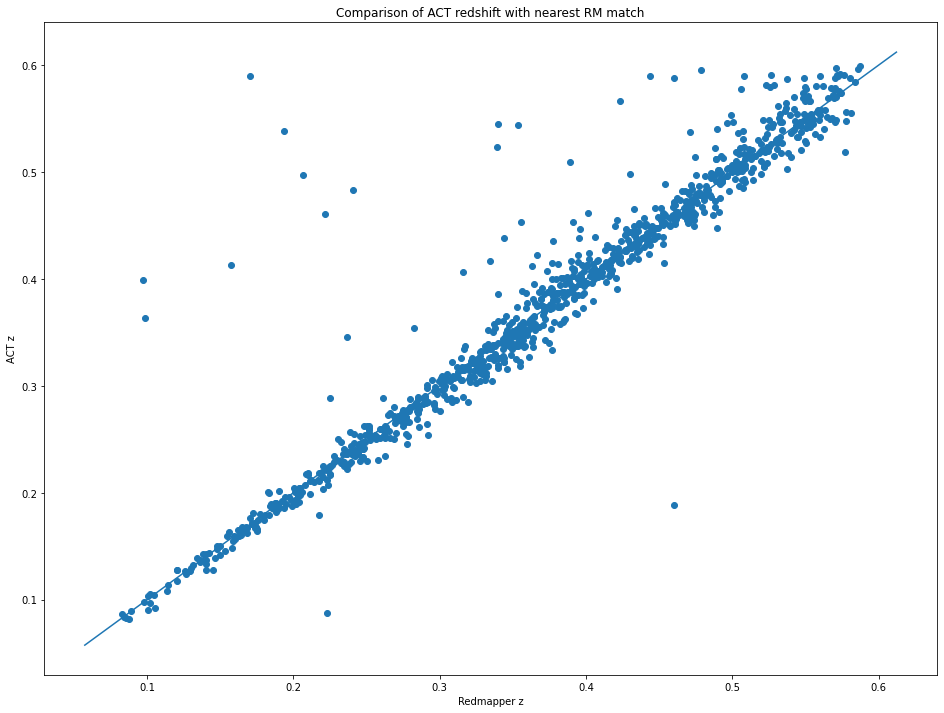

In [26]:
fig,axes = plt.subplots(1,1,figsize=(16,12))

axes.scatter(rmz,z)
abline(1,0)
axes.set_xlabel('Redmapper z')
axes.set_ylabel('ACT z')
axes.set_title('Comparison of ACT redshift with nearest RM match')

In [30]:
ACT_recno=ACT_by_mass.recno
redmapper_recno=rmid
ACT_rm_matches=pd.DataFrame({'ACT_recno': ACT_recno, 'rm_id': redmapper_recno})

In [31]:
#Save the results of a cylindrical match of the redmapper catalog with ACT up to 2.2 r_lambda
ACT_rm_matches.to_pickle("final_ACT_matches_rl2.2.pkl")

In [48]:
ACT=Table.read('../rozo/DR5_cluster-catalog_v1.0.fits')
ACT=ACT.to_pandas()
ACT['recno']=ACT.index.values

In [49]:
RMmatch = np.repeat(-99, len(ACT))

In [50]:
RMmatch[np.array(ACT_rm_matches.ACT_recno)]=ACT_rm_matches.rm_id

In [51]:
ACT['RMmatch']=RMmatch

In [52]:
#Supplement the catalog with the specroscopic galaxy nearest the mass signal

In [54]:
#Mean impute missing values
ACT.loc[ACT.redshiftErr==0.0,'redshiftErr'] = np.mean(ACT[ACT.redshiftErr>0.0].redshiftErr)

act_ra=np.array(np.radians(ACT.RADeg))
act_dec=np.array(np.radians(ACT.decDeg))

spec_ra=np.radians(dr14["PLUG_RA"])
spec_dec=np.radians(dr14["PLUG_DEC"])

nearest_spec_idx=np.empty(len(ACT), dtype=int)

#Find specobj index with smallest angular separation
for i in tqdm(range(len(ACT))):
    sep=np.arccos(np.sin(spec_dec)*math.sin(act_dec[i])+np.cos(spec_dec)*math.cos(act_dec[i])*np.cos(spec_ra-act_ra[i]))
    #angular separation, in radians
    idx=np.min(np.where( sep==np.min(sep) )[0])
    nearest_spec_idx[i]=idx
    
#a strange bit of code needed to make FITS data readable as a pandas
ACT['nearest_ra']=np.array(dr14[nearest_spec_idx].PLUG_RA).byteswap().newbyteorder()
ACT['nearest_dec']=np.array(dr14[nearest_spec_idx].PLUG_DEC).byteswap().newbyteorder()
ACT['nearest_z']=np.array(dr14[nearest_spec_idx].Z).byteswap().newbyteorder()
ACT['nearest_z_err']=np.array(dr14[nearest_spec_idx].Z_ERR).byteswap().newbyteorder()

ACT=ACT[(ACT.redshift>0.1) & (ACT.redshift<0.55)]

  0%|          | 0/4195 [00:00<?, ?it/s]

In [55]:
ACT.to_pickle("ACT_with_rm_matches.pkl")

In [43]:
##########################################################################################################

In [44]:
#Runzscan

In [70]:
ACT=pd.read_pickle("ACT_with_rm_matches.pkl")

In [71]:
#For debugging only; delete.
ACT=ACT[0:10]

In [72]:
#define my data
#inputs
RA=ACT.RADeg #degrees
DEC=ACT.decDeg
z=ACT.redshift
zerr = ACT.redshiftErr
cen_err=(1.483/ACT.fixed_SNR-0.012) #arcminutes
mynearest_ra=ACT.nearest_ra
mynearest_dec=ACT.nearest_dec
nearest_z=ACT.nearest_z
nearest_z_err=ACT.nearest_z_err

#outputs
mylambda=np.repeat(0,len(ACT))

#Define columns by hand? Is there something less ugly?
col1 = fits.Column(name='RA', format='E', array=np.array(RA))
col2 = fits.Column(name='DEC', format='E', array=np.array(DEC))
col3 = fits.Column(name='CEN_ERR', format='E',array=np.array(cen_err))
col4 = fits.Column(name='MYZ', format='E',array=np.array(z))
col5 = fits.Column(name='MYZERR', format='E',array=np.array(zerr))
col6 = fits.Column(name='NEAREST_RA', format='E',array=np.array(mynearest_ra))
col7 = fits.Column(name='NEAREST_DEC', format='E',array=np.array(mynearest_dec))
col8 = fits.Column(name='NEAREST_Z', format='E',array=np.array(nearest_z))
col9 = fits.Column(name='NEAREST_Z_ERR', format='E',array=np.array(nearest_z_err))
col10 = fits.Column(name='MYLAMBDA', format='E',array=np.array(mylambda))
col11 = fits.Column(name='MYLAMBDA_ERR', format='E',array=np.array(mylambda))

coldefs = fits.ColDefs([col1, col2, col3,col4,col5,col6,col7,col8,col9,col10,col11])
hdu = fits.BinTableHDU.from_columns(coldefs)

fname='bigtable.fits'
hdu.writeto(fname,overwrite=True)

In [73]:
file_path = '/home/mr.bwolfe/myredmapper/run'
conffile = 'run.yml'
config = Configuration(file_path + '/' + conffile)
config.catfile = 'bigtable.fits'
config.centerclass = 'WolfeCenteringWcenZred'
fn=file_path + '/' + conffile

In [74]:
start_time = time.time()

withprior = RunZScan(config)
withprior.run()

print("--- %s seconds ---" % (time.time() - start_time))

Reading in catalog file...Wolfe style...
All: Working on cluster 0 of 10
Using WolfeCenteringWcenZred
maskfrac 0.000000
Using WolfeCenteringWcenZred
maskfrac 0.000000
Using WolfeCenteringWcenZred
maskfrac 0.061816
Using WolfeCenteringWcenZred
maskfrac 0.021345
Using WolfeCenteringWcenZred
maskfrac 0.000000
--- 259.35127782821655 seconds ---


In [75]:
withprior.cat.nearest_ra

array([0.11626012, 0.11075634, 0.17832956, 0.35968325, 0.47935915],
      dtype=float32)

In [78]:
ACT_withprior=match_cat_to_zscan(ACT,withprior)

In [80]:
ACT_withprior.to_pickle('ACT_withrprior.pkl')

# Now run the ACT catalog with no prior

In [81]:
config.centerclass = 'CenteringWcenZred'

In [ ]:
start_time = time.time()

noprior = RunZScan(config)
noprior.run()

print("--- %s seconds ---" % (time.time() - start_time))

Reading in catalog file...Wolfe style...
All: Working on cluster 0 of 10


In [ ]:
ACT_noprior=match_cat_to_zscan(ACT,noprior)

In [ ]:
ACT_noprior.to_pickle('ACT_norprior.pkl')

# Now load redMaPPer randoms, create a synthetic catalog, and run it.

The randoms catalog consists of Nrand locations randomly sampled from the redMaPPer randoms.
These locations are randomly given the attributes of one of the clusters in the ACT catalog.

In [ ]:
random = Table.read("../rozo/variance_model/redmapper_dr8_public_v6.3_randoms.fits")
random=random.to_pandas()

In [ ]:
Nrand=10000
paint=ACT.sample(Nrand, replace=True).reset_index(drop=True)

In [ ]:
to_paint=random.sample(Nrand, replace=False).reset_index(drop=True)

In [ ]:
paint.RADeg=to_paint.RA
paint.decDeg=to_paint.DEC

In [ ]:
paint.loc[paint.redshiftErr==0.0,'redshiftErr'] = np.mean(paint[paint.redshiftErr>0.0].redshiftErr)
act_ra=np.array(np.radians(paint.RADeg))
act_dec=np.array(np.radians(paint.decDeg))

spec_ra=np.radians(dr14["PLUG_RA"])
spec_dec=np.radians(dr14["PLUG_DEC"])
nearest_spec_idx=np.empty(len(paint), dtype=int)

for i in tqdm(range(len(paint))):
    sep=np.arccos(np.sin(spec_dec)*math.sin(act_dec[i])+np.cos(spec_dec)*math.cos(act_dec[i])*np.cos(spec_ra-act_ra[i]))
    idx=np.min(np.where( sep==np.min(sep) )[0])
    nearest_spec_idx[i]=idx
    
#a strange bit of code needed to make FITS data readable as a pandas
paint['nearest_ra']=np.array(dr14[nearest_spec_idx].PLUG_RA).byteswap().newbyteorder()
paint['nearest_dec']=np.array(dr14[nearest_spec_idx].PLUG_DEC).byteswap().newbyteorder()
paint['nearest_z']=np.array(dr14[nearest_spec_idx].Z).byteswap().newbyteorder()
paint['nearest_z_err']=np.array(dr14[nearest_spec_idx].Z_ERR).byteswap().newbyteorder()

paint=paint[(paint.redshift>0.1) & (paint.redshift<0.55)]

paint.to_pickle('10000randoms.pkl')

In [24]:
paint=pd.read_pickle('10000randoms.pkl')
#note sig_err

In [25]:
#define my data
RA=paint.RADeg
DEC=paint.decDeg
z=paint.redshift
zerr = paint.redshiftErr
myagn_ra=paint.agn_ra
myagn_dec=paint.agn_dec
agn_z=paint.agn_z
agn_z_err=paint.agn_z_err
#mylambda=paint.mylambda
mylambda=np.repeat(0,len(paint))
cen_err=1.483/paint.fixed_SNR-0.012
#cen_err=r_correction*cen_err

#Define columns by hand? Is there something less ugly?
col1 = fits.Column(name='RA', format='E', array=np.array(RA))
col2 = fits.Column(name='DEC', format='E', array=np.array(DEC))
col3 = fits.Column(name='CEN_ERR', format='E',array=np.array(cen_err))
col4 = fits.Column(name='MYZ', format='E',array=np.array(z))
col5 = fits.Column(name='MYZERR', format='E',array=np.array(zerr))
col6 = fits.Column(name='AGN_RA', format='E',array=np.array(myagn_ra))
col7 = fits.Column(name='AGN_DEC', format='E',array=np.array(myagn_dec))
col8 = fits.Column(name='AGN_Z', format='E',array=np.array(agn_z))
col9 = fits.Column(name='AGN_Z_ERR', format='E',array=np.array(agn_z_err))
col10 = fits.Column(name='MYLAMBDA', format='E',array=np.array(mylambda))
col11 = fits.Column(name='MYLAMBDA_ERR', format='E',array=np.array(mylambda))

coldefs = fits.ColDefs([col1, col2, col3,col4,col5,col6,col7,col8,col9,col10,col11])
hdu = fits.BinTableHDU.from_columns(coldefs)

fname='bigtable.fits'
hdu.writeto(fname,overwrite=True)

In [26]:
file_path = '/home/mr.bwolfe/myredmapper/run'
conffile = 'run.yml'
config = Configuration(file_path + '/' + conffile)
config.catfile = 'bigtable.fits'
config.centerclass = 'WolfeCenteringWcenZred'
fn=file_path + '/' + conffile

In [27]:
start_time = time.time()

bigrandoms = RunZScan(config)
bigrandoms.run()

print("--- %s seconds ---" % (time.time() - start_time))

Length of dr14 after cutting on class: 2779151
Length of dr14 after cutting out suspicious redshifts: 2635685
Reading in catalog file...Wolfe style...
All: Working on cluster 0 of 53457
calcz was passed SZ_z 0.479282, SZ_z_err 0.008210, z_lambda 0.462862
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.479282, SZ_z_err 0.008210, z_lambda 0.414018
calcz was passed SZ_z 0.388230, SZ_z_err 0.019624, z_lambda 0.397232
calcz was passed SZ_z 0.385600, SZ_z_err 0.019624, z_lambda 0.388841
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.385600, SZ_z_err 0.019624, z_lambda 0.389317
calcz was passed SZ_z 0.391459, SZ_z_err 0.019624, z_lambda 0.358693
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.391459, SZ_z_err 0.019624, z_lambda 0.334611
calcz was passed SZ_z 0.374527, SZ_z_err 0.019624, z_lambda 0.378488
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.374527, SZ_z_err 0.019624, z_lambda 0.372030
calcz was passed SZ_z 0.379063, SZ_z_err 0.009784, z_lambda 0.363804
Using Wo

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.251087, SZ_z_err 0.019624, z_lambda 0.241024
calcz was passed SZ_z 0.502100, SZ_z_err 0.027038, z_lambda 0.448024
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.502100, SZ_z_err 0.027038, z_lambda 0.444658
calcz was passed SZ_z 0.404565, SZ_z_err 0.019624, z_lambda 0.417167
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.404565, SZ_z_err 0.019624, z_lambda 0.374775
calcz was passed SZ_z 0.474000, SZ_z_err 0.011496, z_lambda 0.471258
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.474000, SZ_z_err 0.011496, z_lambda 0.505472
calcz was passed SZ_z 0.105011, SZ_z_err 0.019624, z_lambda 0.096010
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.105011, SZ_z_err 0.019624, z_lambda 0.096620
calcz was passed SZ_z 0.407581, SZ_z_err 0.011391, z_lambda 0.388143
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407581, SZ_z_err 0.011391, z_lambda 0.377004
calcz was passed SZ_z 0.264800, SZ_z_err 0.017707, z_lambda 0.22938

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.461000, SZ_z_err 0.011834, z_lambda 0.464182
calcz was passed SZ_z 0.472358, SZ_z_err 0.019624, z_lambda 0.451834
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.472358, SZ_z_err 0.019624, z_lambda 0.442095
calcz was passed SZ_z 0.450486, SZ_z_err 0.019624, z_lambda 0.489733
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.450486, SZ_z_err 0.019624, z_lambda 0.495970
calcz was passed SZ_z 0.477000, SZ_z_err 0.026586, z_lambda 0.517489
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.477000, SZ_z_err 0.026586, z_lambda 0.539264
calcz was passed SZ_z 0.275000, SZ_z_err 0.017850, z_lambda 0.261572
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.275000, SZ_z_err 0.017850, z_lambda 0.271224
calcz was passed SZ_z 0.365953, SZ_z_err 0.019624, z_lambda 0.326706
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.365953, SZ_z_err 0.019624, z_lambda 0.278088
calcz was passed SZ_z 0.320520, SZ_z_err 0.007023, z_lambda 0.333535
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.528790, SZ_z_err 0.019624, z_lambda 0.493143
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.528790, SZ_z_err 0.019624, z_lambda 0.436796
calcz was passed SZ_z 0.326085, SZ_z_err 0.007135, z_lambda 0.340094
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.326085, SZ_z_err 0.007135, z_lambda 0.337172
calcz was passed SZ_z 0.404102, SZ_z_err 0.019624, z_lambda 0.365575
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.404102, SZ_z_err 0.019624, z_lambda 0.363996
calcz was passed SZ_z 0.386985, SZ_z_err 0.019624, z_lambda 0.408949
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.386985, SZ_z_err 0.019624, z_lambda 0.398028
calcz was passed SZ_z 0.388987, SZ_z_err 0.012918, z_lambda 0.368365
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.388987, SZ_z_err 0.012918, z_lambda 0.401754
calcz was passed SZ_z 0.388130, SZ_z_err 0.010323, z_lambda 0.372409
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.388130, SZ_z_err 0.010323, z_lambda 0.39645

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.334927, SZ_z_err 0.019624, z_lambda 0.384501
calcz was passed SZ_z 0.513491, SZ_z_err 0.007117, z_lambda 0.527724
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.513491, SZ_z_err 0.007117, z_lambda 0.580570
calcz was passed SZ_z 0.308000, SZ_z_err 0.019624, z_lambda 0.346527
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.308000, SZ_z_err 0.019624, z_lambda 0.371613
calcz was passed SZ_z 0.351638, SZ_z_err 0.015526, z_lambda 0.320587
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.351638, SZ_z_err 0.015526, z_lambda 0.292478
calcz was passed SZ_z 0.333799, SZ_z_err 0.019624, z_lambda 0.370886
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.333799, SZ_z_err 0.019624, z_lambda 0.290280
calcz was passed SZ_z 0.322300, SZ_z_err 0.019624, z_lambda 0.324820
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.322300, SZ_z_err 0.019624, z_lambda 0.402286
calcz was passed SZ_z 0.362083, SZ_z_err 0.019624, z_lambda 0.33723

calcz was passed SZ_z 0.547300, SZ_z_err 0.019624, z_lambda 0.547660
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.547300, SZ_z_err 0.019624, z_lambda 0.525131
calcz was passed SZ_z 0.195771, SZ_z_err 0.019624, z_lambda 0.202612
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.195771, SZ_z_err 0.019624, z_lambda 0.199656
calcz was passed SZ_z 0.357989, SZ_z_err 0.019624, z_lambda 0.365551
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.357989, SZ_z_err 0.019624, z_lambda 0.374114
calcz was passed SZ_z 0.300599, SZ_z_err 0.006646, z_lambda 0.287307
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.300599, SZ_z_err 0.006646, z_lambda 0.255529
calcz was passed SZ_z 0.412487, SZ_z_err 0.019624, z_lambda 0.381161
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.412487, SZ_z_err 0.019624, z_lambda 0.401046
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.491198
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.48824

calcz was passed SZ_z 0.493858, SZ_z_err 0.019624, z_lambda 0.533106
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.493858, SZ_z_err 0.019624, z_lambda 0.637462
calcz was passed SZ_z 0.399000, SZ_z_err 0.019624, z_lambda 0.402241
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.399000, SZ_z_err 0.019624, z_lambda 0.386888
calcz was passed SZ_z 0.396000, SZ_z_err 0.019624, z_lambda 0.368275
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.396000, SZ_z_err 0.019624, z_lambda 0.328536
calcz was passed SZ_z 0.422447, SZ_z_err 0.013913, z_lambda 0.421171
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.422447, SZ_z_err 0.013913, z_lambda 0.424967
calcz was passed SZ_z 0.420000, SZ_z_err 0.019624, z_lambda 0.380753
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.420000, SZ_z_err 0.019624, z_lambda 0.322017
calcz was passed SZ_z 0.535828, SZ_z_err 0.019624, z_lambda 0.552031
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.535828, SZ_z_err 0.019624, z_lambda 0.50267

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.336000, SZ_z_err 0.019624, z_lambda 0.310040
calcz was passed SZ_z 0.431489, SZ_z_err 0.019624, z_lambda 0.434730
calcz was passed SZ_z 0.359745, SZ_z_err 0.034352, z_lambda 0.372982
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.359745, SZ_z_err 0.034352, z_lambda 0.326036
calcz was passed SZ_z 0.506407, SZ_z_err 0.019624, z_lambda 0.514688
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.506407, SZ_z_err 0.019624, z_lambda 0.506556
calcz was passed SZ_z 0.459000, SZ_z_err 0.019624, z_lambda 0.422633
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.459000, SZ_z_err 0.019624, z_lambda 0.329932
calcz was passed SZ_z 0.506809, SZ_z_err 0.007215, z_lambda 0.500058
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.506809, SZ_z_err 0.007215, z_lambda 0.395102
calcz was passed SZ_z 0.351266, SZ_z_err 0.019624, z_lambda 0.389793
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.351266, SZ_z_err 0.019624, z_lambda 0.43169

calcz was passed SZ_z 0.546096, SZ_z_err 0.019390, z_lambda 0.508738
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.546096, SZ_z_err 0.019390, z_lambda 0.467867
calcz was passed SZ_z 0.472545, SZ_z_err 0.019624, z_lambda 0.475785
calcz was passed SZ_z 0.505200, SZ_z_err 0.027094, z_lambda 0.453001
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.505200, SZ_z_err 0.027094, z_lambda 0.381889
calcz was passed SZ_z 0.407500, SZ_z_err 0.019624, z_lambda 0.439546
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407500, SZ_z_err 0.019624, z_lambda 0.424927
calcz was passed SZ_z 0.380000, SZ_z_err 0.019624, z_lambda 0.366677
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.380000, SZ_z_err 0.019624, z_lambda 0.349340
calcz was passed SZ_z 0.402667, SZ_z_err 0.019624, z_lambda 0.390785
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.402667, SZ_z_err 0.019624, z_lambda 0.275069
calcz was passed SZ_z 0.269860, SZ_z_err 0.019624, z_lambda 0.256538
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.350000, SZ_z_err 0.024300, z_lambda 0.398600
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.350000, SZ_z_err 0.024300, z_lambda 0.404060
calcz was passed SZ_z 0.423000, SZ_z_err 0.019624, z_lambda 0.462247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.423000, SZ_z_err 0.019624, z_lambda 0.487805
calcz was passed SZ_z 0.366800, SZ_z_err 0.019135, z_lambda 0.328530
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.366800, SZ_z_err 0.019135, z_lambda 0.311065
calcz was passed SZ_z 0.254526, SZ_z_err 0.019624, z_lambda 0.278650
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.254526, SZ_z_err 0.019624, z_lambda 0.255227
calcz was passed SZ_z 0.523408, SZ_z_err 0.019624, z_lambda 0.494962
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.523408, SZ_z_err 0.019624, z_lambda 0.494539
calcz was passed SZ_z 0.351266, SZ_z_err 0.019624, z_lambda 0.390513
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.351266, SZ_z_err 0.019624, z_lambda 0.31989

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.350198, SZ_z_err 0.027004, z_lambda 0.418788
calcz was passed SZ_z 0.458758, SZ_z_err 0.019624, z_lambda 0.451917
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.458758, SZ_z_err 0.019624, z_lambda 0.426534
calcz was passed SZ_z 0.388498, SZ_z_err 0.010245, z_lambda 0.391694
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.388498, SZ_z_err 0.010245, z_lambda 0.393976
calcz was passed SZ_z 0.454896, SZ_z_err 0.009304, z_lambda 0.436288
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.454896, SZ_z_err 0.009304, z_lambda 0.387843
calcz was passed SZ_z 0.501519, SZ_z_err 0.014309, z_lambda 0.530137
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.501519, SZ_z_err 0.014309, z_lambda 0.565518
calcz was passed SZ_z 0.461965, SZ_z_err 0.008744, z_lambda 0.445441
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.461965, SZ_z_err 0.008744, z_lambda 0.410575
calcz was passed SZ_z 0.405171, SZ_z_err 0.010673, z_lambda 0.385783
Using WolfeCenteringWcenZre

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.329690, SZ_z_err 0.008273, z_lambda 0.251175
calcz was passed SZ_z 0.528790, SZ_z_err 0.019624, z_lambda 0.496024
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.528790, SZ_z_err 0.019624, z_lambda 0.504349
calcz was passed SZ_z 0.493858, SZ_z_err 0.019624, z_lambda 0.493498
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.493858, SZ_z_err 0.019624, z_lambda 0.488702
calcz was passed SZ_z 0.305771, SZ_z_err 0.019624, z_lambda 0.325574
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.305771, SZ_z_err 0.019624, z_lambda 0.353663
calcz was passed SZ_z 0.431000, SZ_z_err 0.016000, z_lambda 0.399000
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.431000, SZ_z_err 0.016000, z_lambda 0.335457
calcz was passed SZ_z 0.352000, SZ_z_err 0.019624, z_lambda 0.390527
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.352000, SZ_z_err 0.019624, z_lambda 0.420753
calcz was passed SZ_z 0.334927, SZ_z_err 0.019624, z_lambda 0.36409

calcz was passed SZ_z 0.356676, SZ_z_err 0.019624, z_lambda 0.384401
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.356676, SZ_z_err 0.019624, z_lambda 0.385732
calcz was passed SZ_z 0.534899, SZ_z_err 0.019624, z_lambda 0.574147
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.534899, SZ_z_err 0.019624, z_lambda 0.604971
calcz was passed SZ_z 0.458844, SZ_z_err 0.019624, z_lambda 0.477208
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.458844, SZ_z_err 0.019624, z_lambda 0.469979
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.417759
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.274737
calcz was passed SZ_z 0.373435, SZ_z_err 0.019624, z_lambda 0.412683
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.373435, SZ_z_err 0.019624, z_lambda 0.447442
calcz was passed SZ_z 0.465146, SZ_z_err 0.008462, z_lambda 0.448222
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.465146, SZ_z_err 0.008462, z_lambda 0.42920

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.407600, SZ_z_err 0.035940, z_lambda 0.342719
calcz was passed SZ_z 0.201000, SZ_z_err 0.019624, z_lambda 0.222244
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.201000, SZ_z_err 0.019624, z_lambda 0.221039
calcz was passed SZ_z 0.518000, SZ_z_err 0.027324, z_lambda 0.572648
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.518000, SZ_z_err 0.027324, z_lambda 0.602091
calcz was passed SZ_z 0.190000, SZ_z_err 0.023800, z_lambda 0.170349
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.190000, SZ_z_err 0.023800, z_lambda 0.165442
calcz was passed SZ_z 0.176000, SZ_z_err 0.019624, z_lambda 0.161237
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.176000, SZ_z_err 0.019624, z_lambda 0.162726
calcz was passed SZ_z 0.526344, SZ_z_err 0.017996, z_lambda 0.503561
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.526344, SZ_z_err 0.017996, z_lambda 0.485732
calcz was passed SZ_z 0.362500, SZ_z_err 0.019624, z_lambda 0.396707
Using WolfeCenteringWcenZre

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.397000, SZ_z_err 0.019624, z_lambda 0.473802
calcz was passed SZ_z 0.475582, SZ_z_err 0.019624, z_lambda 0.514830
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.475582, SZ_z_err 0.019624, z_lambda 0.504345
calcz was passed SZ_z 0.410000, SZ_z_err 0.019624, z_lambda 0.408920
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.410000, SZ_z_err 0.019624, z_lambda 0.428422
calcz was passed SZ_z 0.541000, SZ_z_err 0.019624, z_lambda 0.554323
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.541000, SZ_z_err 0.019624, z_lambda 0.539596
calcz was passed SZ_z 0.504790, SZ_z_err 0.019624, z_lambda 0.502989
calcz was passed SZ_z 0.450486, SZ_z_err 0.019624, z_lambda 0.411959
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.450486, SZ_z_err 0.019624, z_lambda 0.355215
calcz was passed SZ_z 0.473853, SZ_z_err 0.012248, z_lambda 0.477224
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.473853, SZ_z_err 0.012248, z_lambda 0.44422

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.419055, SZ_z_err 0.019624, z_lambda 0.379807
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.419055, SZ_z_err 0.019624, z_lambda 0.323384
calcz was passed SZ_z 0.449279, SZ_z_err 0.019624, z_lambda 0.412192
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.449279, SZ_z_err 0.019624, z_lambda 0.397195
calcz was passed SZ_z 0.339246, SZ_z_err 0.019624, z_lambda 0.378493
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.339246, SZ_z_err 0.019624, z_lambda 0.383382
calcz was passed SZ_z 0.358200, SZ_z_err 0.024380, z_lambda 0.309440
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.358200, SZ_z_err 0.024380, z_lambda 0.263902
All: Working on cluster 7000 of 53457
calcz was passed SZ_z 0.240629, SZ_z_err 0.019624, z_lambda 0.258992
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.240629, SZ_z_err 0.019624, z_lambda 0.250060
calcz was passed SZ_z 0.397106, SZ_z_err 0.010304, z_lambda 0.377633
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.39710

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.415293, SZ_z_err 0.010774, z_lambda 0.438822
calcz was passed SZ_z 0.305634, SZ_z_err 0.019624, z_lambda 0.336240
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.305634, SZ_z_err 0.019624, z_lambda 0.342526
calcz was passed SZ_z 0.402840, SZ_z_err 0.011575, z_lambda 0.379690
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.402840, SZ_z_err 0.011575, z_lambda 0.316552
calcz was passed SZ_z 0.359000, SZ_z_err 0.019624, z_lambda 0.398247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.359000, SZ_z_err 0.019624, z_lambda 0.386865
calcz was passed SZ_z 0.347368, SZ_z_err 0.019624, z_lambda 0.386615
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.347368, SZ_z_err 0.019624, z_lambda 0.409113
calcz was passed SZ_z 0.372857, SZ_z_err 0.019624, z_lambda 0.377538
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.372857, SZ_z_err 0.019624, z_lambda 0.360088
calcz was passed SZ_z 0.357689, SZ_z_err 0.019624, z_lambda 0.39621

All: Working on cluster 8000 of 53457
calcz was passed SZ_z 0.399000, SZ_z_err 0.019624, z_lambda 0.368394
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.399000, SZ_z_err 0.019624, z_lambda 0.316782


/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.356800, SZ_z_err 0.024422, z_lambda 0.381446
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.356800, SZ_z_err 0.024422, z_lambda 0.393340
calcz was passed SZ_z 0.514531, SZ_z_err 0.019624, z_lambda 0.514171
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.514531, SZ_z_err 0.019624, z_lambda 0.488683
calcz was passed SZ_z 0.525358, SZ_z_err 0.007213, z_lambda 0.510933
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.525358, SZ_z_err 0.007213, z_lambda 0.453705
calcz was passed SZ_z 0.433987, SZ_z_err 0.019624, z_lambda 0.422824
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.433987, SZ_z_err 0.019624, z_lambda 0.434963
calcz was passed SZ_z 0.518343, SZ_z_err 0.019624, z_lambda 0.557590
calcz was passed SZ_z 0.411769, SZ_z_err 0.034577, z_lambda 0.446664
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.411769, SZ_z_err 0.034577, z_lambda 0.434812
calcz was passed SZ_z 0.462083, SZ_z_err 0.012754, z_lambda 0.436574
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.318543, SZ_z_err 0.019624, z_lambda 0.342667
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.318543, SZ_z_err 0.019624, z_lambda 0.391486
calcz was passed SZ_z 0.338322, SZ_z_err 0.019624, z_lambda 0.375409
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.338322, SZ_z_err 0.019624, z_lambda 0.372989
calcz was passed SZ_z 0.207810, SZ_z_err 0.004086, z_lambda 0.215981
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.207810, SZ_z_err 0.004086, z_lambda 0.233861
calcz was passed SZ_z 0.545884, SZ_z_err 0.019624, z_lambda 0.506637
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.545884, SZ_z_err 0.019624, z_lambda 0.471639
calcz was passed SZ_z 0.424950, SZ_z_err 0.019624, z_lambda 0.407307
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.424950, SZ_z_err 0.019624, z_lambda 0.378039
calcz was passed SZ_z 0.286633, SZ_z_err 0.006835, z_lambda 0.300302
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.286633, SZ_z_err 0.006835, z_lambda 0.36608

calcz was passed SZ_z 0.544666, SZ_z_err 0.019624, z_lambda 0.466527
calcz was passed SZ_z 0.475354, SZ_z_err 0.007492, z_lambda 0.473842
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.475354, SZ_z_err 0.007492, z_lambda 0.473063
calcz was passed SZ_z 0.437872, SZ_z_err 0.009646, z_lambda 0.457164
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.437872, SZ_z_err 0.009646, z_lambda 0.475605
calcz was passed SZ_z 0.276900, SZ_z_err 0.019624, z_lambda 0.296704
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.276900, SZ_z_err 0.019624, z_lambda 0.314840
calcz was passed SZ_z 0.234200, SZ_z_err 0.017279, z_lambda 0.214860
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.234200, SZ_z_err 0.017279, z_lambda 0.213242
calcz was passed SZ_z 0.547029, SZ_z_err 0.020277, z_lambda 0.510196
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.547029, SZ_z_err 0.020277, z_lambda 0.492490
calcz was passed SZ_z 0.438200, SZ_z_err 0.020135, z_lambda 0.478470
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.449085, SZ_z_err 0.019624, z_lambda 0.424241
calcz was passed SZ_z 0.338100, SZ_z_err 0.024086, z_lambda 0.384504
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.338100, SZ_z_err 0.024086, z_lambda 0.434198
calcz was passed SZ_z 0.270484, SZ_z_err 0.019624, z_lambda 0.239158
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.270484, SZ_z_err 0.019624, z_lambda 0.228041
calcz was passed SZ_z 0.498200, SZ_z_err 0.026968, z_lambda 0.444265
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.498200, SZ_z_err 0.026968, z_lambda 0.318458
calcz was passed SZ_z 0.456700, SZ_z_err 0.026221, z_lambda 0.459106
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.456700, SZ_z_err 0.026221, z_lambda 0.466126
calcz was passed SZ_z 0.455530, SZ_z_err 0.019624, z_lambda 0.432845
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.455530, SZ_z_err 0.019624, z_lambda 0.428294
calcz was passed SZ_z 0.230880, SZ_z_err 0.019624, z_lambda 0.265087
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.251788, SZ_z_err 0.019624, z_lambda 0.324180
calcz was passed SZ_z 0.242428, SZ_z_err 0.005340, z_lambda 0.250561
calcz was passed SZ_z 0.302495, SZ_z_err 0.006326, z_lambda 0.315147
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.302495, SZ_z_err 0.006326, z_lambda 0.329862
calcz was passed SZ_z 0.186000, SZ_z_err 0.009607, z_lambda 0.166787
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.186000, SZ_z_err 0.009607, z_lambda 0.171011
calcz was passed SZ_z 0.251183, SZ_z_err 0.019624, z_lambda 0.289710
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.251183, SZ_z_err 0.019624, z_lambda 0.309774
calcz was passed SZ_z 0.219544, SZ_z_err 0.006178, z_lambda 0.231900
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.219544, SZ_z_err 0.006178, z_lambda 0.234778
All: Working on cluster 10000 of 53457
calcz was passed SZ_z 0.479078, SZ_z_err 0.007424, z_lambda 0.481394
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.479078, SZ_z_err 0.007424, z_lamb

calcz was passed SZ_z 0.370577, SZ_z_err 0.009576, z_lambda 0.382014
calcz was passed SZ_z 0.349054, SZ_z_err 0.019624, z_lambda 0.388301
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.349054, SZ_z_err 0.019624, z_lambda 0.418981
calcz was passed SZ_z 0.469000, SZ_z_err 0.019624, z_lambda 0.438394
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.469000, SZ_z_err 0.019624, z_lambda 0.400544
calcz was passed SZ_z 0.454896, SZ_z_err 0.009304, z_lambda 0.471114
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.454896, SZ_z_err 0.009304, z_lambda 0.479150
calcz was passed SZ_z 0.522900, SZ_z_err 0.027412, z_lambda 0.502278
calcz was passed SZ_z 0.337400, SZ_z_err 0.008861, z_lambda 0.355123
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.337400, SZ_z_err 0.008861, z_lambda 0.384745
calcz was passed SZ_z 0.359695, SZ_z_err 0.008923, z_lambda 0.365425
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.359695, SZ_z_err 0.008923, z_lambda 0.387077
calcz was passed SZ_z 0.478

calcz was passed SZ_z 0.525290, SZ_z_err 0.006575, z_lambda 0.527099
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.525290, SZ_z_err 0.006575, z_lambda 0.534865
calcz was passed SZ_z 0.419000, SZ_z_err 0.019624, z_lambda 0.419360
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.419000, SZ_z_err 0.019624, z_lambda 0.396955
calcz was passed SZ_z 0.407581, SZ_z_err 0.011391, z_lambda 0.430363
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407581, SZ_z_err 0.011391, z_lambda 0.550682
calcz was passed SZ_z 0.455000, SZ_z_err 0.019624, z_lambda 0.434476
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.455000, SZ_z_err 0.019624, z_lambda 0.393103
calcz was passed SZ_z 0.447750, SZ_z_err 0.019624, z_lambda 0.430827
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.447750, SZ_z_err 0.019624, z_lambda 0.436300
calcz was passed SZ_z 0.278000, SZ_z_err 0.019624, z_lambda 0.297084
calcz was passed SZ_z 0.453228, SZ_z_err 0.009562, z_lambda 0.434105
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.206000, SZ_z_err 0.019624, z_lambda 0.209241
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.206000, SZ_z_err 0.019624, z_lambda 0.196436
calcz was passed SZ_z 0.446284, SZ_z_err 0.019624, z_lambda 0.479770
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.446284, SZ_z_err 0.019624, z_lambda 0.467050
calcz was passed SZ_z 0.255717, SZ_z_err 0.019624, z_lambda 0.288484
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.255717, SZ_z_err 0.019624, z_lambda 0.292180
calcz was passed SZ_z 0.382186, SZ_z_err 0.033433, z_lambda 0.434329
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.382186, SZ_z_err 0.033433, z_lambda 0.421558
calcz was passed SZ_z 0.459080, SZ_z_err 0.010981, z_lambda 0.441550
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.459080, SZ_z_err 0.010981, z_lambda 0.443674
calcz was passed SZ_z 0.204365, SZ_z_err 0.019624, z_lambda 0.224889
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.204365, SZ_z_err 0.019624, z_lambda 0.23372

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.154700, SZ_z_err 0.020785, z_lambda 0.161436
calcz was passed SZ_z 0.448400, SZ_z_err 0.020278, z_lambda 0.413054
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.448400, SZ_z_err 0.020278, z_lambda 0.364258
calcz was passed SZ_z 0.215702, SZ_z_err 0.004743, z_lambda 0.225013
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.215702, SZ_z_err 0.004743, z_lambda 0.275245
calcz was passed SZ_z 0.230300, SZ_z_err 0.022145, z_lambda 0.235582
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.230300, SZ_z_err 0.022145, z_lambda 0.232935
calcz was passed SZ_z 0.167886, SZ_z_err 0.023358, z_lambda 0.173457
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.167886, SZ_z_err 0.023358, z_lambda 0.196413
All: Working on cluster 12000 of 53457
calcz was passed SZ_z 0.448400, SZ_z_err 0.020278, z_lambda 0.411565
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.448400, SZ_z_err 0.020278, z_lambda 0.389421
calcz was passed SZ_z 0.493641, SZ_z_err 0.007940, z_lamb

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.502055, SZ_z_err 0.019624, z_lambda 0.536005
calcz was passed SZ_z 0.346447, SZ_z_err 0.019624, z_lambda 0.384254
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.346447, SZ_z_err 0.019624, z_lambda 0.409322
calcz was passed SZ_z 0.381960, SZ_z_err 0.019624, z_lambda 0.395283
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.381960, SZ_z_err 0.019624, z_lambda 0.399127
calcz was passed SZ_z 0.417577, SZ_z_err 0.013364, z_lambda 0.444305
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.417577, SZ_z_err 0.013364, z_lambda 0.458248
calcz was passed SZ_z 0.478586, SZ_z_err 0.019624, z_lambda 0.517113
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.478586, SZ_z_err 0.019624, z_lambda 0.368892
calcz was passed SZ_z 0.397462, SZ_z_err 0.010159, z_lambda 0.377143
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.397462, SZ_z_err 0.010159, z_lambda 0.313690
calcz was passed SZ_z 0.130012, SZ_z_err 0.004738, z_lambda 0.136880
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.284000, SZ_z_err 0.019624, z_lambda 0.254834
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.284000, SZ_z_err 0.019624, z_lambda 0.242436
calcz was passed SZ_z 0.224674, SZ_z_err 0.004689, z_lambda 0.223555
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.224674, SZ_z_err 0.004689, z_lambda 0.223655
calcz was passed SZ_z 0.435804, SZ_z_err 0.010559, z_lambda 0.415073
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.435804, SZ_z_err 0.010559, z_lambda 0.374975
calcz was passed SZ_z 0.417288, SZ_z_err 0.012369, z_lambda 0.441119
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.417288, SZ_z_err 0.012369, z_lambda 0.498499
calcz was passed SZ_z 0.458400, SZ_z_err 0.019624, z_lambda 0.473163
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.458400, SZ_z_err 0.019624, z_lambda 0.421183
calcz was passed SZ_z 0.352000, SZ_z_err 0.019624, z_lambda 0.371084
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.352000, SZ_z_err 0.019624, z_lambda 0.34316

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.492000, SZ_z_err 0.019624, z_lambda 0.506763
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.492000, SZ_z_err 0.019624, z_lambda 0.516592
calcz was passed SZ_z 0.424950, SZ_z_err 0.019624, z_lambda 0.464198
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.424950, SZ_z_err 0.019624, z_lambda 0.486254
calcz was passed SZ_z 0.411537, SZ_z_err 0.012336, z_lambda 0.387317
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.411537, SZ_z_err 0.012336, z_lambda 0.328649
calcz was passed SZ_z 0.412000, SZ_z_err 0.019624, z_lambda 0.451247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.412000, SZ_z_err 0.019624, z_lambda 0.512046
calcz was passed SZ_z 0.473853, SZ_z_err 0.012248, z_lambda 0.449807
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.473853, SZ_z_err 0.012248, z_lambda 0.451602
calcz was passed SZ_z 0.322285, SZ_z_err 0.019624, z_lambda 0.283038
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.322285, SZ_z_err 0.019624, z_lambda 0.27048

calcz was passed SZ_z 0.438200, SZ_z_err 0.020135, z_lambda 0.477731
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.438200, SZ_z_err 0.020135, z_lambda 0.513359
calcz was passed SZ_z 0.247508, SZ_z_err 0.004750, z_lambda 0.257007
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.247508, SZ_z_err 0.004750, z_lambda 0.310099
calcz was passed SZ_z 0.512600, SZ_z_err 0.027227, z_lambda 0.472134
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.512600, SZ_z_err 0.027227, z_lambda 0.445778
calcz was passed SZ_z 0.310066, SZ_z_err 0.026201, z_lambda 0.359584
calcz was passed SZ_z 0.408820, SZ_z_err 0.019624, z_lambda 0.409900
calcz was passed SZ_z 0.263300, SZ_z_err 0.022739, z_lambda 0.258710
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.263300, SZ_z_err 0.022739, z_lambda 0.274180
calcz was passed SZ_z 0.395649, SZ_z_err 0.010703, z_lambda 0.375421
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.395649, SZ_z_err 0.010703, z_lambda 0.348812
calcz was passed SZ_z 0.339

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.511839, SZ_z_err 0.019624, z_lambda 0.392417
calcz was passed SZ_z 0.408114, SZ_z_err 0.011462, z_lambda 0.428936
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.408114, SZ_z_err 0.011462, z_lambda 0.411827
calcz was passed SZ_z 0.413201, SZ_z_err 0.019624, z_lambda 0.452449
calcz was passed SZ_z 0.544519, SZ_z_err 0.015978, z_lambda 0.572957
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.544519, SZ_z_err 0.015978, z_lambda 0.631876
calcz was passed SZ_z 0.192113, SZ_z_err 0.004770, z_lambda 0.184499
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.192113, SZ_z_err 0.004770, z_lambda 0.175791
calcz was passed SZ_z 0.450000, SZ_z_err 0.019624, z_lambda 0.412193
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.450000, SZ_z_err 0.019624, z_lambda 0.412560
calcz was passed SZ_z 0.393000, SZ_z_err 0.019624, z_lambda 0.355193
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.393000, SZ_z_err 0.019624, z_lambda 0.342174
calcz was passed SZ_z 0.439

calcz was passed SZ_z 0.428000, SZ_z_err 0.019992, z_lambda 0.402689
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.428000, SZ_z_err 0.019992, z_lambda 0.397897
calcz was passed SZ_z 0.299000, SZ_z_err 0.019624, z_lambda 0.302241
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.299000, SZ_z_err 0.019624, z_lambda 0.269480
calcz was passed SZ_z 0.270484, SZ_z_err 0.019624, z_lambda 0.243479
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.270484, SZ_z_err 0.019624, z_lambda 0.250346
calcz was passed SZ_z 0.515277, SZ_z_err 0.019624, z_lambda 0.548763
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.515277, SZ_z_err 0.019624, z_lambda 0.509953
calcz was passed SZ_z 0.366800, SZ_z_err 0.019135, z_lambda 0.328530
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.366800, SZ_z_err 0.019135, z_lambda 0.320554
calcz was passed SZ_z 0.357385, SZ_z_err 0.019624, z_lambda 0.385831
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.357385, SZ_z_err 0.019624, z_lambda 0.37459

calcz was passed SZ_z 0.470300, SZ_z_err 0.019624, z_lambda 0.495865
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.470300, SZ_z_err 0.019624, z_lambda 0.496146
calcz was passed SZ_z 0.498200, SZ_z_err 0.026968, z_lambda 0.485830
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.498200, SZ_z_err 0.026968, z_lambda 0.464328
calcz was passed SZ_z 0.484050, SZ_z_err 0.019624, z_lambda 0.519697
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.484050, SZ_z_err 0.019624, z_lambda 0.515252
calcz was passed SZ_z 0.254000, SZ_z_err 0.019624, z_lambda 0.286046
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.254000, SZ_z_err 0.019624, z_lambda 0.267539
calcz was passed SZ_z 0.482431, SZ_z_err 0.019624, z_lambda 0.447504
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.482431, SZ_z_err 0.019624, z_lambda 0.436998
calcz was passed SZ_z 0.304699, SZ_z_err 0.019624, z_lambda 0.265451
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.304699, SZ_z_err 0.019624, z_lambda 0.25115

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407600, SZ_z_err 0.019706, z_lambda 0.363554
calcz was passed SZ_z 0.429530, SZ_z_err 0.019624, z_lambda 0.468057
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.429530, SZ_z_err 0.019624, z_lambda 0.531859
calcz was passed SZ_z 0.479282, SZ_z_err 0.008210, z_lambda 0.495702
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.479282, SZ_z_err 0.008210, z_lambda 0.517284
calcz was passed SZ_z 0.460100, SZ_z_err 0.019624, z_lambda 0.423013
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.460100, SZ_z_err 0.019624, z_lambda 0.397770
calcz was passed SZ_z 0.385600, SZ_z_err 0.019624, z_lambda 0.384520
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.385600, SZ_z_err 0.019624, z_lambda 0.273405
calcz was passed SZ_z 0.407190, SZ_z_err 0.019624, z_lambda 0.426993
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407190, SZ_z_err 0.019624, z_lambda 0.405993
calcz was passed SZ_z 0.291786, SZ_z_err 0.019624, z_lambda 0.31375

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.279486, SZ_z_err 0.005595, z_lambda 0.271000
calcz was passed SZ_z 0.310066, SZ_z_err 0.026201, z_lambda 0.257663
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.310066, SZ_z_err 0.026201, z_lambda 0.278649
calcz was passed SZ_z 0.434300, SZ_z_err 0.011618, z_lambda 0.413196
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.434300, SZ_z_err 0.011618, z_lambda 0.401422
calcz was passed SZ_z 0.480608, SZ_z_err 0.019624, z_lambda 0.519856
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.480608, SZ_z_err 0.019624, z_lambda 0.567030
calcz was passed SZ_z 0.373810, SZ_z_err 0.019624, z_lambda 0.369849
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.373810, SZ_z_err 0.019624, z_lambda 0.373350
calcz was passed SZ_z 0.475979, SZ_z_err 0.019624, z_lambda 0.515226
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.475979, SZ_z_err 0.019624, z_lambda 0.550669
calcz was passed SZ_z 0.444867, SZ_z_err 0.010182, z_lambda 0.46485

calcz was passed SZ_z 0.421329, SZ_z_err 0.013640, z_lambda 0.447840
calcz was passed SZ_z 0.228000, SZ_z_err 0.019624, z_lambda 0.265087
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.228000, SZ_z_err 0.019624, z_lambda 0.245521
calcz was passed SZ_z 0.412130, SZ_z_err 0.011935, z_lambda 0.436000
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.412130, SZ_z_err 0.011935, z_lambda 0.453328
calcz was passed SZ_z 0.395646, SZ_z_err 0.014972, z_lambda 0.368449
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.395646, SZ_z_err 0.014972, z_lambda 0.371128
calcz was passed SZ_z 0.337270, SZ_z_err 0.019624, z_lambda 0.376517
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.337270, SZ_z_err 0.019624, z_lambda 0.389129
calcz was passed SZ_z 0.292400, SZ_z_err 0.019624, z_lambda 0.284118
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.292400, SZ_z_err 0.019624, z_lambda 0.276008
calcz was passed SZ_z 0.482233, SZ_z_err 0.019624, z_lambda 0.520040
calcz was passed SZ_z 0.544

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.408879, SZ_z_err 0.010221, z_lambda 0.388436
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.408879, SZ_z_err 0.010221, z_lambda 0.398123
calcz was passed SZ_z 0.493858, SZ_z_err 0.019624, z_lambda 0.515822
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.493858, SZ_z_err 0.019624, z_lambda 0.540847
calcz was passed SZ_z 0.222197, SZ_z_err 0.019624, z_lambda 0.244882
Using WolfeCenteringWcenZred


/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.222197, SZ_z_err 0.019624, z_lambda 0.244512
calcz was passed SZ_z 0.344248, SZ_z_err 0.008905, z_lambda 0.358137
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.344248, SZ_z_err 0.008905, z_lambda 0.398782
All: Working on cluster 17000 of 53457
calcz was passed SZ_z 0.438700, SZ_z_err 0.025897, z_lambda 0.477189
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.438700, SZ_z_err 0.025897, z_lambda 0.457572
calcz was passed SZ_z 0.275000, SZ_z_err 0.017850, z_lambda 0.258296
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.275000, SZ_z_err 0.017850, z_lambda 0.267875
calcz was passed SZ_z 0.277110, SZ_z_err 0.019624, z_lambda 0.316357
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.277110, SZ_z_err 0.019624, z_lambda 0.292313
calcz was passed SZ_z 0.391925, SZ_z_err 0.010461, z_lambda 0.374074
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.391925, SZ_z_err 0.010461, z_lambda 0.362775
calcz was passed SZ_z 0.351532, SZ_z_err 0.008712, z_lamb

calcz was passed SZ_z 0.429373, SZ_z_err 0.019624, z_lambda 0.391566
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.429373, SZ_z_err 0.019624, z_lambda 0.376176
calcz was passed SZ_z 0.497219, SZ_z_err 0.019624, z_lambda 0.457971
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.497219, SZ_z_err 0.019624, z_lambda 0.320094
calcz was passed SZ_z 0.488476, SZ_z_err 0.019624, z_lambda 0.519082
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.488476, SZ_z_err 0.019624, z_lambda 0.476996
calcz was passed SZ_z 0.398860, SZ_z_err 0.010745, z_lambda 0.378158
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.398860, SZ_z_err 0.010745, z_lambda 0.340872
calcz was passed SZ_z 0.510954, SZ_z_err 0.019624, z_lambda 0.543000
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.510954, SZ_z_err 0.019624, z_lambda 0.534030
calcz was passed SZ_z 0.508612, SZ_z_err 0.019624, z_lambda 0.469364
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.508612, SZ_z_err 0.019624, z_lambda 0.39320

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.264000, SZ_z_err 0.025000, z_lambda 0.237987
calcz was passed SZ_z 0.226000, SZ_z_err 0.022068, z_lambda 0.270136
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.226000, SZ_z_err 0.022068, z_lambda 0.330472
calcz was passed SZ_z 0.492151, SZ_z_err 0.019624, z_lambda 0.452904
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.492151, SZ_z_err 0.019624, z_lambda 0.295963
calcz was passed SZ_z 0.409959, SZ_z_err 0.010842, z_lambda 0.430848
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.409959, SZ_z_err 0.010842, z_lambda 0.434618
calcz was passed SZ_z 0.516413, SZ_z_err 0.019624, z_lambda 0.555661
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.516413, SZ_z_err 0.019624, z_lambda 0.575436
calcz was passed SZ_z 0.176500, SZ_z_err 0.019624, z_lambda 0.170379
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.176500, SZ_z_err 0.019624, z_lambda 0.169523
calcz was passed SZ_z 0.350000, SZ_z_err 0.019624, z_lambda 0.37412

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.428645, SZ_z_err 0.019624, z_lambda 0.467893
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.428645, SZ_z_err 0.019624, z_lambda 0.550836
calcz was passed SZ_z 0.287700, SZ_z_err 0.023910, z_lambda 0.240757
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.287700, SZ_z_err 0.023910, z_lambda 0.249635
calcz was passed SZ_z 0.389067, SZ_z_err 0.027781, z_lambda 0.333504
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.389067, SZ_z_err 0.027781, z_lambda 0.301584
calcz was passed SZ_z 0.407753, SZ_z_err 0.015508, z_lambda 0.383566
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407753, SZ_z_err 0.015508, z_lambda 0.385194
calcz was passed SZ_z 0.469040, SZ_z_err 0.011194, z_lambda 0.491018
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.469040, SZ_z_err 0.011194, z_lambda 0.517946
calcz was passed SZ_z 0.535124, SZ_z_err 0.019624, z_lambda 0.496597
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.535124, SZ_z_err 0.019624, z_lambda 0.47270

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.351000, SZ_z_err 0.019624, z_lambda 0.434270
calcz was passed SZ_z 0.414941, SZ_z_err 0.019624, z_lambda 0.408100
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.414941, SZ_z_err 0.019624, z_lambda 0.420846
calcz was passed SZ_z 0.331234, SZ_z_err 0.007297, z_lambda 0.316641
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.331234, SZ_z_err 0.007297, z_lambda 0.217604
calcz was passed SZ_z 0.276646, SZ_z_err 0.006306, z_lambda 0.264033
calcz was passed SZ_z 0.367636, SZ_z_err 0.009342, z_lambda 0.351694
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.367636, SZ_z_err 0.009342, z_lambda 0.324336
calcz was passed SZ_z 0.490497, SZ_z_err 0.012006, z_lambda 0.494242
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.490497, SZ_z_err 0.012006, z_lambda 0.512999
calcz was passed SZ_z 0.397400, SZ_z_err 0.019564, z_lambda 0.423604
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.397400, SZ_z_err 0.019564, z_lambda 0.452394
calcz was passed SZ_z 0.461

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.403837, SZ_z_err 0.012962, z_lambda 0.426179
calcz was passed SZ_z 0.521000, SZ_z_err 0.027378, z_lambda 0.466244
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.521000, SZ_z_err 0.027378, z_lambda 0.418386
calcz was passed SZ_z 0.331100, SZ_z_err 0.019624, z_lambda 0.321378
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.331100, SZ_z_err 0.019624, z_lambda 0.293430
calcz was passed SZ_z 0.350733, SZ_z_err 0.019624, z_lambda 0.311485
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.350733, SZ_z_err 0.019624, z_lambda 0.286585
calcz was passed SZ_z 0.367854, SZ_z_err 0.027357, z_lambda 0.393454
calcz was passed SZ_z 0.373435, SZ_z_err 0.019624, z_lambda 0.375236
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.373435, SZ_z_err 0.019624, z_lambda 0.367689
calcz was passed SZ_z 0.413704, SZ_z_err 0.010099, z_lambda 0.433903
Using WolfeCenteringWcenZred


/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.413704, SZ_z_err 0.010099, z_lambda 0.451425
calcz was passed SZ_z 0.454731, SZ_z_err 0.019624, z_lambda 0.463733
calcz was passed SZ_z 0.451801, SZ_z_err 0.008435, z_lambda 0.455980
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.451801, SZ_z_err 0.008435, z_lambda 0.451980
calcz was passed SZ_z 0.316542, SZ_z_err 0.008469, z_lambda 0.330993
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.316542, SZ_z_err 0.008469, z_lambda 0.333625
calcz was passed SZ_z 0.459000, SZ_z_err 0.019624, z_lambda 0.498247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.459000, SZ_z_err 0.019624, z_lambda 0.599229
calcz was passed SZ_z 0.403527, SZ_z_err 0.012154, z_lambda 0.389031
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.403527, SZ_z_err 0.012154, z_lambda 0.377150
calcz was passed SZ_z 0.344314, SZ_z_err 0.015520, z_lambda 0.313275
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.344314, SZ_z_err 0.015520, z_lambda 0.287916
calcz was passed SZ_z 0.285

calcz was passed SZ_z 0.361900, SZ_z_err 0.024514, z_lambda 0.392037
Using WolfeCenteringWcenZred


/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.361900, SZ_z_err 0.024514, z_lambda 0.354210
calcz was passed SZ_z 0.422272, SZ_z_err 0.013796, z_lambda 0.449863
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.422272, SZ_z_err 0.013796, z_lambda 0.489260
calcz was passed SZ_z 0.417288, SZ_z_err 0.012369, z_lambda 0.393458
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.417288, SZ_z_err 0.012369, z_lambda 0.349124
calcz was passed SZ_z 0.230000, SZ_z_err 0.019624, z_lambda 0.257725
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.230000, SZ_z_err 0.019624, z_lambda 0.230029
calcz was passed SZ_z 0.462127, SZ_z_err 0.011570, z_lambda 0.481020
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.462127, SZ_z_err 0.011570, z_lambda 0.380824
calcz was passed SZ_z 0.453774, SZ_z_err 0.019624, z_lambda 0.493022
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.453774, SZ_z_err 0.019624, z_lambda 0.482113
calcz was passed SZ_z 0.243954, SZ_z_err 0.019624, z_lambda 0.233512
calcz was passed SZ_z 0.284

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.381266, SZ_z_err 0.019624, z_lambda 0.420513
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.381266, SZ_z_err 0.019624, z_lambda 0.441105
calcz was passed SZ_z 0.148300, SZ_z_err 0.019624, z_lambda 0.124896
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.148300, SZ_z_err 0.019624, z_lambda 0.121432
calcz was passed SZ_z 0.399000, SZ_z_err 0.019624, z_lambda 0.361193
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.399000, SZ_z_err 0.019624, z_lambda 0.316365
calcz was passed SZ_z 0.390546, SZ_z_err 0.014311, z_lambda 0.419167
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.390546, SZ_z_err 0.014311, z_lambda 0.415815
calcz was passed SZ_z 0.361900, SZ_z_err 0.024514, z_lambda 0.315570
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.361900, SZ_z_err 0.024514, z_lambda 0.313331
calcz was passed SZ_z 0.402000, SZ_z_err 0.019624, z_lambda 0.364193
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.402000, SZ_z_err 0.019624, z_lambda 0.36892

calcz was passed SZ_z 0.529440, SZ_z_err 0.018721, z_lambda 0.508869
calcz was passed SZ_z 0.293700, SZ_z_err 0.023287, z_lambda 0.269345
calcz was passed SZ_z 0.280800, SZ_z_err 0.023054, z_lambda 0.323525
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.280800, SZ_z_err 0.023054, z_lambda 0.345803
calcz was passed SZ_z 0.317000, SZ_z_err 0.019624, z_lambda 0.288555
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.317000, SZ_z_err 0.019624, z_lambda 0.276208
calcz was passed SZ_z 0.409959, SZ_z_err 0.010842, z_lambda 0.411750
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.409959, SZ_z_err 0.010842, z_lambda 0.393626
calcz was passed SZ_z 0.312688, SZ_z_err 0.019624, z_lambda 0.329611
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.312688, SZ_z_err 0.019624, z_lambda 0.338338
calcz was passed SZ_z 0.546419, SZ_z_err 0.023203, z_lambda 0.500012
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.546419, SZ_z_err 0.023203, z_lambda 0.382843
calcz was passed SZ_z 0.238

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.290740, SZ_z_err 0.006156, z_lambda 0.319874
calcz was passed SZ_z 0.351266, SZ_z_err 0.019624, z_lambda 0.312018
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.351266, SZ_z_err 0.019624, z_lambda 0.288040
calcz was passed SZ_z 0.391459, SZ_z_err 0.019624, z_lambda 0.393979
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.391459, SZ_z_err 0.019624, z_lambda 0.375439
calcz was passed SZ_z 0.234001, SZ_z_err 0.019624, z_lambda 0.227160
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.234001, SZ_z_err 0.019624, z_lambda 0.234611
calcz was passed SZ_z 0.310008, SZ_z_err 0.006676, z_lambda 0.320176
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.310008, SZ_z_err 0.006676, z_lambda 0.310061
calcz was passed SZ_z 0.295757, SZ_z_err 0.006770, z_lambda 0.308552
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.295757, SZ_z_err 0.006770, z_lambda 0.289323
calcz was passed SZ_z 0.219816, SZ_z_err 0.004763, z_lambda 0.228816
Using WolfeCenteringWcenZre

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.453300, SZ_z_err 0.026159, z_lambda 0.510940
calcz was passed SZ_z 0.498062, SZ_z_err 0.019624, z_lambda 0.478258
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.498062, SZ_z_err 0.019624, z_lambda 0.464885
calcz was passed SZ_z 0.260000, SZ_z_err 0.019624, z_lambda 0.237316
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.260000, SZ_z_err 0.019624, z_lambda 0.249200
calcz was passed SZ_z 0.314369, SZ_z_err 0.019624, z_lambda 0.353617
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.314369, SZ_z_err 0.019624, z_lambda 0.387146
calcz was passed SZ_z 0.407797, SZ_z_err 0.019624, z_lambda 0.368550
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407797, SZ_z_err 0.019624, z_lambda 0.339486
calcz was passed SZ_z 0.453228, SZ_z_err 0.009562, z_lambda 0.443228
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.453228, SZ_z_err 0.009562, z_lambda 0.380199
calcz was passed SZ_z 0.225000, SZ_z_err 0.013000, z_lambda 0.19947

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.177100, SZ_z_err 0.021188, z_lambda 0.210150
calcz was passed SZ_z 0.443000, SZ_z_err 0.019624, z_lambda 0.454882
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.443000, SZ_z_err 0.019624, z_lambda 0.438841
calcz was passed SZ_z 0.519800, SZ_z_err 0.021277, z_lambda 0.562354
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.519800, SZ_z_err 0.021277, z_lambda 0.615375
calcz was passed SZ_z 0.326684, SZ_z_err 0.006956, z_lambda 0.312772
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.326684, SZ_z_err 0.006956, z_lambda 0.327826
calcz was passed SZ_z 0.520100, SZ_z_err 0.027362, z_lambda 0.572815
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.520100, SZ_z_err 0.027362, z_lambda 0.566314
calcz was passed SZ_z 0.191315, SZ_z_err 0.019624, z_lambda 0.203197
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.191315, SZ_z_err 0.019624, z_lambda 0.194283
calcz was passed SZ_z 0.458758, SZ_z_err 0.019624, z_lambda 0.466320
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.438200, SZ_z_err 0.020135, z_lambda 0.473297
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.438200, SZ_z_err 0.020135, z_lambda 0.553673
calcz was passed SZ_z 0.506764, SZ_z_err 0.006658, z_lambda 0.493691
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.506764, SZ_z_err 0.006658, z_lambda 0.449901
calcz was passed SZ_z 0.390000, SZ_z_err 0.020000, z_lambda 0.365413
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.390000, SZ_z_err 0.020000, z_lambda 0.334113
calcz was passed SZ_z 0.275000, SZ_z_err 0.017850, z_lambda 0.289739
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.275000, SZ_z_err 0.017850, z_lambda 0.314410
calcz was passed SZ_z 0.471070, SZ_z_err 0.019624, z_lambda 0.451986
calcz was passed SZ_z 0.438000, SZ_z_err 0.019624, z_lambda 0.398753
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.438000, SZ_z_err 0.019624, z_lambda 0.344801
calcz was passed SZ_z 0.454731, SZ_z_err 0.019624, z_lambda 0.421245
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.302495, SZ_z_err 0.006326, z_lambda 0.310968
calcz was passed SZ_z 0.512343, SZ_z_err 0.006652, z_lambda 0.499040
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.512343, SZ_z_err 0.006652, z_lambda 0.440208
calcz was passed SZ_z 0.438000, SZ_z_err 0.019624, z_lambda 0.465725
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.438000, SZ_z_err 0.019624, z_lambda 0.503709
calcz was passed SZ_z 0.313203, SZ_z_err 0.007450, z_lambda 0.328103
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.313203, SZ_z_err 0.007450, z_lambda 0.424948
calcz was passed SZ_z 0.482499, SZ_z_err 0.011721, z_lambda 0.505510
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.482499, SZ_z_err 0.011721, z_lambda 0.643666
calcz was passed SZ_z 0.471919, SZ_z_err 0.019624, z_lambda 0.510447
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.471919, SZ_z_err 0.019624, z_lambda 0.548728
calcz was passed SZ_z 0.530658, SZ_z_err 0.016861, z_lambda 0.501267
calcz was passed SZ_z 0.400

calcz was passed SZ_z 0.422447, SZ_z_err 0.013913, z_lambda 0.448232
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.422447, SZ_z_err 0.013913, z_lambda 0.433875
calcz was passed SZ_z 0.351970, SZ_z_err 0.019624, z_lambda 0.333607
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.351970, SZ_z_err 0.019624, z_lambda 0.352384
calcz was passed SZ_z 0.439285, SZ_z_err 0.019624, z_lambda 0.473492
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.439285, SZ_z_err 0.019624, z_lambda 0.472546
calcz was passed SZ_z 0.408534, SZ_z_err 0.019624, z_lambda 0.386569
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.408534, SZ_z_err 0.019624, z_lambda 0.356791
All: Working on cluster 23000 of 53457
calcz was passed SZ_z 0.338081, SZ_z_err 0.019624, z_lambda 0.341322
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.338081, SZ_z_err 0.019624, z_lambda 0.357717
calcz was passed SZ_z 0.525500, SZ_z_err 0.027459, z_lambda 0.470582
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.5255

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.251000, SZ_z_err 0.019624, z_lambda 0.284672
calcz was passed SZ_z 0.227500, SZ_z_err 0.019624, z_lambda 0.249464
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.227500, SZ_z_err 0.019624, z_lambda 0.259798
calcz was passed SZ_z 0.368400, SZ_z_err 0.024631, z_lambda 0.334504
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.368400, SZ_z_err 0.024631, z_lambda 0.370006
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.417759
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.325081
calcz was passed SZ_z 0.267500, SZ_z_err 0.022815, z_lambda 0.241964
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.267500, SZ_z_err 0.022815, z_lambda 0.266448
calcz was passed SZ_z 0.314247, SZ_z_err 0.008007, z_lambda 0.330262
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.314247, SZ_z_err 0.008007, z_lambda 0.329819
calcz was passed SZ_z 0.280149, SZ_z_err 0.011670, z_lambda 0.282932
Using WolfeCenteringWcenZre

Using WolfeCenteringWcenZred


/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.295424, SZ_z_err 0.006382, z_lambda 0.362910
calcz was passed SZ_z 0.421000, SZ_z_err 0.019624, z_lambda 0.421360
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.421000, SZ_z_err 0.019624, z_lambda 0.432583
calcz was passed SZ_z 0.432826, SZ_z_err 0.019624, z_lambda 0.472073
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.432826, SZ_z_err 0.019624, z_lambda 0.446229
calcz was passed SZ_z 0.373800, SZ_z_err 0.024728, z_lambda 0.334325
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.373800, SZ_z_err 0.024728, z_lambda 0.328194
calcz was passed SZ_z 0.500574, SZ_z_err 0.019624, z_lambda 0.461327
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.500574, SZ_z_err 0.019624, z_lambda 0.402661
calcz was passed SZ_z 0.439597, SZ_z_err 0.019624, z_lambda 0.400350
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.439597, SZ_z_err 0.019624, z_lambda 0.400406
calcz was passed SZ_z 0.259000, SZ_z_err 0.019624, z_lambda 0.298247
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.375300, SZ_z_err 0.024755, z_lambda 0.422994
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.375300, SZ_z_err 0.024755, z_lambda 0.409678
calcz was passed SZ_z 0.530995, SZ_z_err 0.009770, z_lambda 0.549101
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.530995, SZ_z_err 0.009770, z_lambda 0.545741
calcz was passed SZ_z 0.451580, SZ_z_err 0.019624, z_lambda 0.429615
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.451580, SZ_z_err 0.019624, z_lambda 0.404568
calcz was passed SZ_z 0.255528, SZ_z_err 0.005796, z_lambda 0.266907
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.255528, SZ_z_err 0.005796, z_lambda 0.293124
calcz was passed SZ_z 0.421329, SZ_z_err 0.013640, z_lambda 0.446607
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.421329, SZ_z_err 0.013640, z_lambda 0.428497
calcz was passed SZ_z 0.255717, SZ_z_err 0.019624, z_lambda 0.248876
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.255717, SZ_z_err 0.019624, z_lambda 0.27710

calcz was passed SZ_z 0.437823, SZ_z_err 0.010837, z_lambda 0.417741
calcz was passed SZ_z 0.336000, SZ_z_err 0.019624, z_lambda 0.324838
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.336000, SZ_z_err 0.019624, z_lambda 0.328756
calcz was passed SZ_z 0.332651, SZ_z_err 0.019624, z_lambda 0.294844
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.332651, SZ_z_err 0.019624, z_lambda 0.274085
calcz was passed SZ_z 0.406000, SZ_z_err 0.019624, z_lambda 0.427964
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.406000, SZ_z_err 0.019624, z_lambda 0.421847
calcz was passed SZ_z 0.326080, SZ_z_err 0.019624, z_lambda 0.287552
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.326080, SZ_z_err 0.019624, z_lambda 0.267258
calcz was passed SZ_z 0.254600, SZ_z_err 0.017564, z_lambda 0.220116
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.254600, SZ_z_err 0.017564, z_lambda 0.216397
calcz was passed SZ_z 0.407797, SZ_z_err 0.019624, z_lambda 0.444885
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.407600, SZ_z_err 0.019706, z_lambda 0.445566
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407600, SZ_z_err 0.019706, z_lambda 0.495972
calcz was passed SZ_z 0.377671, SZ_z_err 0.009818, z_lambda 0.358397
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.377671, SZ_z_err 0.009818, z_lambda 0.323183
calcz was passed SZ_z 0.383677, SZ_z_err 0.019624, z_lambda 0.381156
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.383677, SZ_z_err 0.019624, z_lambda 0.395738
calcz was passed SZ_z 0.546100, SZ_z_err 0.027830, z_lambda 0.527206
calcz was passed SZ_z 0.284000, SZ_z_err 0.019624, z_lambda 0.277159
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.284000, SZ_z_err 0.019624, z_lambda 0.274286
calcz was passed SZ_z 0.446255, SZ_z_err 0.019624, z_lambda 0.430052
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.446255, SZ_z_err 0.019624, z_lambda 0.424269
calcz was passed SZ_z 0.416541, SZ_z_err 0.013250, z_lambda 0.443040
Using WolfeCenteringWcenZre

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.329462, SZ_z_err 0.019624, z_lambda 0.406958
calcz was passed SZ_z 0.483518, SZ_z_err 0.019624, z_lambda 0.517725
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.483518, SZ_z_err 0.019624, z_lambda 0.525953
calcz was passed SZ_z 0.421908, SZ_z_err 0.019624, z_lambda 0.433790
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.421908, SZ_z_err 0.019624, z_lambda 0.425823
calcz was passed SZ_z 0.285200, SZ_z_err 0.017993, z_lambda 0.286190
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.285200, SZ_z_err 0.017993, z_lambda 0.291414
calcz was passed SZ_z 0.376369, SZ_z_err 0.017983, z_lambda 0.387918
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.376369, SZ_z_err 0.017983, z_lambda 0.385263
calcz was passed SZ_z 0.454200, SZ_z_err 0.026176, z_lambda 0.423942
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.454200, SZ_z_err 0.026176, z_lambda 0.402911
calcz was passed SZ_z 0.498062, SZ_z_err 0.019624, z_lambda 0.47465

calcz was passed SZ_z 0.365000, SZ_z_err 0.019624, z_lambda 0.354558
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.365000, SZ_z_err 0.019624, z_lambda 0.365560
calcz was passed SZ_z 0.546437, SZ_z_err 0.039515, z_lambda 0.518160
calcz was passed SZ_z 0.390546, SZ_z_err 0.014311, z_lambda 0.374003
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.390546, SZ_z_err 0.014311, z_lambda 0.356924
calcz was passed SZ_z 0.441700, SZ_z_err 0.019624, z_lambda 0.480947
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.441700, SZ_z_err 0.019624, z_lambda 0.531428
All: Working on cluster 27000 of 53457
calcz was passed SZ_z 0.373435, SZ_z_err 0.019624, z_lambda 0.357953
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.373435, SZ_z_err 0.019624, z_lambda 0.332623
calcz was passed SZ_z 0.546096, SZ_z_err 0.019390, z_lambda 0.508738
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.546096, SZ_z_err 0.019390, z_lambda 0.501607
calcz was passed SZ_z 0.355668, SZ_z_err 0.019624, z_lamb

calcz was passed SZ_z 0.297379, SZ_z_err 0.025948, z_lambda 0.332135
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.297379, SZ_z_err 0.025948, z_lambda 0.288945
calcz was passed SZ_z 0.444718, SZ_z_err 0.011727, z_lambda 0.466451
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.444718, SZ_z_err 0.011727, z_lambda 0.452158
calcz was passed SZ_z 0.423500, SZ_z_err 0.019624, z_lambda 0.426020
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.423500, SZ_z_err 0.019624, z_lambda 0.408314
calcz was passed SZ_z 0.317000, SZ_z_err 0.019624, z_lambda 0.288555
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.317000, SZ_z_err 0.019624, z_lambda 0.292741
calcz was passed SZ_z 0.438642, SZ_z_err 0.009052, z_lambda 0.455418
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.438642, SZ_z_err 0.009052, z_lambda 0.449306
calcz was passed SZ_z 0.441430, SZ_z_err 0.019624, z_lambda 0.402903
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.441430, SZ_z_err 0.019624, z_lambda 0.39646

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.425000, SZ_z_err 0.019624, z_lambda 0.411269
calcz was passed SZ_z 0.211633, SZ_z_err 0.019624, z_lambda 0.227116
Using WolfeCenteringWcenZred


/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.211633, SZ_z_err 0.019624, z_lambda 0.224873
calcz was passed SZ_z 0.525500, SZ_z_err 0.027459, z_lambda 0.501820
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.525500, SZ_z_err 0.027459, z_lambda 0.511482
calcz was passed SZ_z 0.396894, SZ_z_err 0.011504, z_lambda 0.402593
calcz was passed SZ_z 0.304418, SZ_z_err 0.006743, z_lambda 0.316419
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.304418, SZ_z_err 0.006743, z_lambda 0.335544
calcz was passed SZ_z 0.353950, SZ_z_err 0.019624, z_lambda 0.321184
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.353950, SZ_z_err 0.019624, z_lambda 0.315880
calcz was passed SZ_z 0.301761, SZ_z_err 0.015567, z_lambda 0.274625
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.301761, SZ_z_err 0.015567, z_lambda 0.271985
calcz was passed SZ_z 0.396776, SZ_z_err 0.011210, z_lambda 0.375179
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.396776, SZ_z_err 0.011210, z_lambda 0.311863
calcz was passed SZ_z 0.323

calcz was passed SZ_z 0.478900, SZ_z_err 0.026620, z_lambda 0.519441
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.478900, SZ_z_err 0.026620, z_lambda 0.528747
calcz was passed SZ_z 0.448036, SZ_z_err 0.019624, z_lambda 0.473601
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.448036, SZ_z_err 0.019624, z_lambda 0.482549
calcz was passed SZ_z 0.399000, SZ_z_err 0.019624, z_lambda 0.410882
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.399000, SZ_z_err 0.019624, z_lambda 0.390986
calcz was passed SZ_z 0.374527, SZ_z_err 0.019624, z_lambda 0.336000
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.374527, SZ_z_err 0.019624, z_lambda 0.316446
calcz was passed SZ_z 0.281614, SZ_z_err 0.010850, z_lambda 0.302915
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.281614, SZ_z_err 0.010850, z_lambda 0.313755
calcz was passed SZ_z 0.503589, SZ_z_err 0.019624, z_lambda 0.484505
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.503589, SZ_z_err 0.019624, z_lambda 0.54127

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.472290, SZ_z_err 0.019624, z_lambda 0.441578
calcz was passed SZ_z 0.342756, SZ_z_err 0.019624, z_lambda 0.366160
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.342756, SZ_z_err 0.019624, z_lambda 0.361676
calcz was passed SZ_z 0.217000, SZ_z_err 0.021906, z_lambda 0.260812
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.217000, SZ_z_err 0.021906, z_lambda 0.211448
calcz was passed SZ_z 0.322787, SZ_z_err 0.047058, z_lambda 0.347827
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.322787, SZ_z_err 0.047058, z_lambda 0.365255
calcz was passed SZ_z 0.308000, SZ_z_err 0.019624, z_lambda 0.347247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.308000, SZ_z_err 0.019624, z_lambda 0.379446
calcz was passed SZ_z 0.422979, SZ_z_err 0.012353, z_lambda 0.398273
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.422979, SZ_z_err 0.012353, z_lambda 0.398300
calcz was passed SZ_z 0.501793, SZ_z_err 0.019624, z_lambda 0.462546
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.540200, SZ_z_err 0.021563, z_lambda 0.624065
calcz was passed SZ_z 0.285300, SZ_z_err 0.023135, z_lambda 0.260254
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.285300, SZ_z_err 0.023135, z_lambda 0.256388
calcz was passed SZ_z 0.338867, SZ_z_err 0.008207, z_lambda 0.355282
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.338867, SZ_z_err 0.008207, z_lambda 0.369817
calcz was passed SZ_z 0.167168, SZ_z_err 0.019624, z_lambda 0.176169
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.167168, SZ_z_err 0.019624, z_lambda 0.185795
calcz was passed SZ_z 0.296000, SZ_z_err 0.019624, z_lambda 0.288439
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.296000, SZ_z_err 0.019624, z_lambda 0.287814
calcz was passed SZ_z 0.493595, SZ_z_err 0.008093, z_lambda 0.508594
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.493595, SZ_z_err 0.008093, z_lambda 0.244420
calcz was passed SZ_z 0.498489, SZ_z_err 0.019624, z_lambda 0.473644
Using WolfeCenteringWcenZre

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.336813, SZ_z_err 0.019624, z_lambda 0.371257
calcz was passed SZ_z 0.471264, SZ_z_err 0.019624, z_lambda 0.510511
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.471264, SZ_z_err 0.019624, z_lambda 0.580352
All: Working on cluster 30000 of 53457
calcz was passed SZ_z 0.403527, SZ_z_err 0.012154, z_lambda 0.427834
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.403527, SZ_z_err 0.012154, z_lambda 0.426750
calcz was passed SZ_z 0.326737, SZ_z_err 0.019624, z_lambda 0.291090
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.326737, SZ_z_err 0.019624, z_lambda 0.250748
calcz was passed SZ_z 0.297528, SZ_z_err 0.019624, z_lambda 0.331015
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.297528, SZ_z_err 0.019624, z_lambda 0.321968
calcz was passed SZ_z 0.392395, SZ_z_err 0.019624, z_lambda 0.429482
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.392395, SZ_z_err 0.019624, z_lambda 0.398828
calcz was passed SZ_z 0.4250

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.420700, SZ_z_err 0.019624, z_lambda 0.476251
calcz was passed SZ_z 0.238292, SZ_z_err 0.008371, z_lambda 0.255034
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.238292, SZ_z_err 0.008371, z_lambda 0.295175
calcz was passed SZ_z 0.499400, SZ_z_err 0.020992, z_lambda 0.459728
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.499400, SZ_z_err 0.020992, z_lambda 0.401553
calcz was passed SZ_z 0.513955, SZ_z_err 0.019624, z_lambda 0.541680
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.513955, SZ_z_err 0.019624, z_lambda 0.552695
calcz was passed SZ_z 0.297497, SZ_z_err 0.015222, z_lambda 0.327381
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.297497, SZ_z_err 0.015222, z_lambda 0.311988
calcz was passed SZ_z 0.471264, SZ_z_err 0.019624, z_lambda 0.510511
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.471264, SZ_z_err 0.019624, z_lambda 0.442660
calcz was passed SZ_z 0.438200, SZ_z_err 0.020135, z_lambda 0.43265

calcz was passed SZ_z 0.295757, SZ_z_err 0.006770, z_lambda 0.267579
calcz was passed SZ_z 0.301477, SZ_z_err 0.019624, z_lambda 0.340004
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.301477, SZ_z_err 0.019624, z_lambda 0.353472
calcz was passed SZ_z 0.336000, SZ_z_err 0.019624, z_lambda 0.375247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.336000, SZ_z_err 0.019624, z_lambda 0.329044
calcz was passed SZ_z 0.259892, SZ_z_err 0.019624, z_lambda 0.270334
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.259892, SZ_z_err 0.019624, z_lambda 0.308855
calcz was passed SZ_z 0.371084, SZ_z_err 0.010750, z_lambda 0.349583
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.371084, SZ_z_err 0.010750, z_lambda 0.293393
calcz was passed SZ_z 0.432671, SZ_z_err 0.009719, z_lambda 0.424290
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.432671, SZ_z_err 0.009719, z_lambda 0.412902
calcz was passed SZ_z 0.513955, SZ_z_err 0.019624, z_lambda 0.476148
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.217227, SZ_z_err 0.004047, z_lambda 0.197746
calcz was passed SZ_z 0.522000, SZ_z_err 0.019624, z_lambda 0.482753
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.522000, SZ_z_err 0.019624, z_lambda 0.457522
calcz was passed SZ_z 0.501340, SZ_z_err 0.007440, z_lambda 0.496289
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.501340, SZ_z_err 0.007440, z_lambda 0.437968
calcz was passed SZ_z 0.355000, SZ_z_err 0.019624, z_lambda 0.323674
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.355000, SZ_z_err 0.019624, z_lambda 0.334691
calcz was passed SZ_z 0.368400, SZ_z_err 0.010012, z_lambda 0.388057
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.368400, SZ_z_err 0.010012, z_lambda 0.437422
calcz was passed SZ_z 0.439108, SZ_z_err 0.010252, z_lambda 0.454721
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.439108, SZ_z_err 0.010252, z_lambda 0.443026
calcz was passed SZ_z 0.505400, SZ_z_err 0.027097, z_lambda 0.559594
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.230300, SZ_z_err 0.022145, z_lambda 0.224618
calcz was passed SZ_z 0.417800, SZ_z_err 0.019849, z_lambda 0.388299
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.417800, SZ_z_err 0.019849, z_lambda 0.377001
calcz was passed SZ_z 0.513248, SZ_z_err 0.019624, z_lambda 0.477601
calcz was passed SZ_z 0.222166, SZ_z_err 0.004524, z_lambda 0.214113
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.222166, SZ_z_err 0.004524, z_lambda 0.208102
calcz was passed SZ_z 0.351000, SZ_z_err 0.019624, z_lambda 0.331916
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.351000, SZ_z_err 0.019624, z_lambda 0.312995
calcz was passed SZ_z 0.453092, SZ_z_err 0.019624, z_lambda 0.440489
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.453092, SZ_z_err 0.019624, z_lambda 0.451558
calcz was passed SZ_z 0.177926, SZ_z_err 0.019624, z_lambda 0.157402
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.177926, SZ_z_err 0.019624, z_lambda 0.157119
calcz was passed SZ_z 0.363

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.280042, SZ_z_err 0.010999, z_lambda 0.231052
calcz was passed SZ_z 0.518913, SZ_z_err 0.019624, z_lambda 0.479665
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.518913, SZ_z_err 0.019624, z_lambda 0.453566
calcz was passed SZ_z 0.328346, SZ_z_err 0.007537, z_lambda 0.342590
calcz was passed SZ_z 0.164700, SZ_z_err 0.019624, z_lambda 0.146337
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.164700, SZ_z_err 0.019624, z_lambda 0.153282
calcz was passed SZ_z 0.278100, SZ_z_err 0.019624, z_lambda 0.302945
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.278100, SZ_z_err 0.019624, z_lambda 0.304831
calcz was passed SZ_z 0.268993, SZ_z_err 0.025380, z_lambda 0.226616
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.268993, SZ_z_err 0.025380, z_lambda 0.234649
calcz was passed SZ_z 0.537711, SZ_z_err 0.019624, z_lambda 0.517907
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.537711, SZ_z_err 0.019624, z_lambda 0.516887
calcz was passed SZ_z 0.254

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.317396, SZ_z_err 0.019624, z_lambda 0.307674
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.317396, SZ_z_err 0.019624, z_lambda 0.310029
calcz was passed SZ_z 0.320000, SZ_z_err 0.019624, z_lambda 0.357087
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.320000, SZ_z_err 0.019624, z_lambda 0.372831
calcz was passed SZ_z 0.441171, SZ_z_err 0.019624, z_lambda 0.455934
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.441171, SZ_z_err 0.019624, z_lambda 0.445358
calcz was passed SZ_z 0.474300, SZ_z_err 0.026537, z_lambda 0.484525
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.474300, SZ_z_err 0.026537, z_lambda 0.478320
calcz was passed SZ_z 0.502722, SZ_z_err 0.019624, z_lambda 0.541969
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.502722, SZ_z_err 0.019624, z_lambda 0.567597
calcz was passed SZ_z 0.480608, SZ_z_err 0.019624, z_lambda 0.441361
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.480608, SZ_z_err 0.019624, z_lambda 0.38578

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.226187, SZ_z_err 0.007713, z_lambda 0.173402
calcz was passed SZ_z 0.230880, SZ_z_err 0.019624, z_lambda 0.199555
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.230880, SZ_z_err 0.019624, z_lambda 0.218491
calcz was passed SZ_z 0.314706, SZ_z_err 0.008080, z_lambda 0.329679
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.314706, SZ_z_err 0.008080, z_lambda 0.358752
All: Working on cluster 33000 of 53457
calcz was passed SZ_z 0.284069, SZ_z_err 0.019624, z_lambda 0.300992
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.284069, SZ_z_err 0.019624, z_lambda 0.304409
calcz was passed SZ_z 0.540386, SZ_z_err 0.006293, z_lambda 0.531495
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.540386, SZ_z_err 0.006293, z_lambda 0.440750
calcz was passed SZ_z 0.254526, SZ_z_err 0.019624, z_lambda 0.262087
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.254526, SZ_z_err 0.019624, z_lambda 0.266143
calcz was passed SZ_z 0.373800, SZ_z_err 0.024728, z_lamb

calcz was passed SZ_z 0.415848, SZ_z_err 0.019624, z_lambda 0.455096
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.415848, SZ_z_err 0.019624, z_lambda 0.496817
calcz was passed SZ_z 0.414293, SZ_z_err 0.010489, z_lambda 0.421799
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.414293, SZ_z_err 0.010489, z_lambda 0.411317
calcz was passed SZ_z 0.236163, SZ_z_err 0.007346, z_lambda 0.229558
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.236163, SZ_z_err 0.007346, z_lambda 0.216775
calcz was passed SZ_z 0.443198, SZ_z_err 0.009391, z_lambda 0.460257
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.443198, SZ_z_err 0.009391, z_lambda 0.574745
calcz was passed SZ_z 0.544000, SZ_z_err 0.019624, z_lambda 0.505473
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.544000, SZ_z_err 0.019624, z_lambda 0.471468
calcz was passed SZ_z 0.320399, SZ_z_err 0.019624, z_lambda 0.281152
calcz was passed SZ_z 0.211484, SZ_z_err 0.019624, z_lambda 0.234888
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.475979, SZ_z_err 0.019624, z_lambda 0.513786
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.475979, SZ_z_err 0.019624, z_lambda 0.568450
calcz was passed SZ_z 0.320000, SZ_z_err 0.019624, z_lambda 0.342684
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.320000, SZ_z_err 0.019624, z_lambda 0.346613
calcz was passed SZ_z 0.292400, SZ_z_err 0.019624, z_lambda 0.300682
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.292400, SZ_z_err 0.019624, z_lambda 0.295420
calcz was passed SZ_z 0.262088, SZ_z_err 0.019624, z_lambda 0.300615
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.262088, SZ_z_err 0.019624, z_lambda 0.292593
calcz was passed SZ_z 0.259300, SZ_z_err 0.022667, z_lambda 0.299644
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.259300, SZ_z_err 0.022667, z_lambda 0.375418
calcz was passed SZ_z 0.376343, SZ_z_err 0.010285, z_lambda 0.391251
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.376343, SZ_z_err 0.010285, z_lambda 0.40061

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.351000, SZ_z_err 0.019624, z_lambda 0.303635
calcz was passed SZ_z 0.475059, SZ_z_err 0.008266, z_lambda 0.458830
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.475059, SZ_z_err 0.008266, z_lambda 0.388444
calcz was passed SZ_z 0.300599, SZ_z_err 0.006646, z_lambda 0.309745
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.300599, SZ_z_err 0.006646, z_lambda 0.310288
calcz was passed SZ_z 0.279741, SZ_z_err 0.005911, z_lambda 0.291562
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.279741, SZ_z_err 0.005911, z_lambda 0.382315
calcz was passed SZ_z 0.395941, SZ_z_err 0.019624, z_lambda 0.433028
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.395941, SZ_z_err 0.019624, z_lambda 0.411354
calcz was passed SZ_z 0.278245, SZ_z_err 0.005890, z_lambda 0.266464
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.278245, SZ_z_err 0.005890, z_lambda 0.215460
calcz was passed SZ_z 0.385017, SZ_z_err 0.019624, z_lambda 0.383937
calcz was passed SZ_z 0.468

calcz was passed SZ_z 0.536687, SZ_z_err 0.006350, z_lambda 0.524220
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.536687, SZ_z_err 0.006350, z_lambda 0.475456
calcz was passed SZ_z 0.506333, SZ_z_err 0.019624, z_lambda 0.472127
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.506333, SZ_z_err 0.019624, z_lambda 0.457124
calcz was passed SZ_z 0.460000, SZ_z_err 0.029200, z_lambda 0.517328
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.460000, SZ_z_err 0.029200, z_lambda 0.526269
calcz was passed SZ_z 0.393407, SZ_z_err 0.011527, z_lambda 0.402502
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.393407, SZ_z_err 0.011527, z_lambda 0.405163
calcz was passed SZ_z 0.388987, SZ_z_err 0.012918, z_lambda 0.413400
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.388987, SZ_z_err 0.012918, z_lambda 0.428955
calcz was passed SZ_z 0.365953, SZ_z_err 0.019624, z_lambda 0.342549
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.365953, SZ_z_err 0.019624, z_lambda 0.34474

calcz was passed SZ_z 0.514460, SZ_z_err 0.007095, z_lambda 0.500531
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.514460, SZ_z_err 0.007095, z_lambda 0.486748
calcz was passed SZ_z 0.251183, SZ_z_err 0.019624, z_lambda 0.252263
calcz was passed SZ_z 0.393700, SZ_z_err 0.019624, z_lambda 0.427907
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.393700, SZ_z_err 0.019624, z_lambda 0.422151
calcz was passed SZ_z 0.263600, SZ_z_err 0.019624, z_lambda 0.287725
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.263600, SZ_z_err 0.019624, z_lambda 0.337153
calcz was passed SZ_z 0.515770, SZ_z_err 0.006621, z_lambda 0.502528
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.515770, SZ_z_err 0.006621, z_lambda 0.466577
calcz was passed SZ_z 0.493570, SZ_z_err 0.019624, z_lambda 0.532817
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.493570, SZ_z_err 0.019624, z_lambda 0.549555
calcz was passed SZ_z 0.415137, SZ_z_err 0.019624, z_lambda 0.439261
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.385577, SZ_z_err 0.011262, z_lambda 0.405208
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.385577, SZ_z_err 0.011262, z_lambda 0.372505
calcz was passed SZ_z 0.536192, SZ_z_err 0.008197, z_lambda 0.520399
calcz was passed SZ_z 0.447300, SZ_z_err 0.026051, z_lambda 0.464030
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.447300, SZ_z_err 0.026051, z_lambda 0.452444
calcz was passed SZ_z 0.514460, SZ_z_err 0.007095, z_lambda 0.500792
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.514460, SZ_z_err 0.007095, z_lambda 0.462691
calcz was passed SZ_z 0.397000, SZ_z_err 0.019624, z_lambda 0.436247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.397000, SZ_z_err 0.019624, z_lambda 0.441683
calcz was passed SZ_z 0.475059, SZ_z_err 0.008266, z_lambda 0.458527
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.475059, SZ_z_err 0.008266, z_lambda 0.390108
calcz was passed SZ_z 0.461000, SZ_z_err 0.019624, z_lambda 0.495927
calcz was passed SZ_z 0.350

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.190528, SZ_z_err 0.019624, z_lambda 0.217933
calcz was passed SZ_z 0.285588, SZ_z_err 0.006087, z_lambda 0.291284
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.285588, SZ_z_err 0.006087, z_lambda 0.251951
calcz was passed SZ_z 0.432826, SZ_z_err 0.019624, z_lambda 0.465592
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.432826, SZ_z_err 0.019624, z_lambda 0.496152
calcz was passed SZ_z 0.407104, SZ_z_err 0.019624, z_lambda 0.369296
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407104, SZ_z_err 0.019624, z_lambda 0.332045
calcz was passed SZ_z 0.452847, SZ_z_err 0.009852, z_lambda 0.433142
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.452847, SZ_z_err 0.009852, z_lambda 0.348456
calcz was passed SZ_z 0.440319, SZ_z_err 0.010748, z_lambda 0.461026
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.440319, SZ_z_err 0.010748, z_lambda 0.500906
calcz was passed SZ_z 0.362083, SZ_z_err 0.019624, z_lambda 0.393409
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.317000, SZ_z_err 0.019624, z_lambda 0.356247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.317000, SZ_z_err 0.019624, z_lambda 0.312057
calcz was passed SZ_z 0.319600, SZ_z_err 0.019624, z_lambda 0.316359
All: Working on cluster 36000 of 53457
calcz was passed SZ_z 0.284879, SZ_z_err 0.019624, z_lambda 0.245632
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.284879, SZ_z_err 0.019624, z_lambda 0.223770
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.423005
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.402643
calcz was passed SZ_z 0.189445, SZ_z_err 0.023789, z_lambda 0.189882
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.189445, SZ_z_err 0.023789, z_lambda 0.182905
calcz was passed SZ_z 0.317500, SZ_z_err 0.019624, z_lambda 0.350266
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.317500, SZ_z_err 0.019624, z_lambda 0.421748
calcz was passed SZ_z 0.497300, SZ_z_err 0.026951, z_lamb

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.497300, SZ_z_err 0.026951, z_lambda 0.538689
calcz was passed SZ_z 0.106435, SZ_z_err 0.022129, z_lambda 0.105216
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.106435, SZ_z_err 0.022129, z_lambda 0.101782
calcz was passed SZ_z 0.337000, SZ_z_err 0.019624, z_lambda 0.302073
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.337000, SZ_z_err 0.019624, z_lambda 0.295665
calcz was passed SZ_z 0.380000, SZ_z_err 0.019624, z_lambda 0.402684
calcz was passed SZ_z 0.496589, SZ_z_err 0.019624, z_lambda 0.466703
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.496589, SZ_z_err 0.019624, z_lambda 0.310072
calcz was passed SZ_z 0.438200, SZ_z_err 0.020135, z_lambda 0.397930
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.438200, SZ_z_err 0.020135, z_lambda 0.265029
calcz was passed SZ_z 0.349889, SZ_z_err 0.008769, z_lambda 0.365496
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.349889, SZ_z_err 0.008769, z_lambda 0.341839
calcz was passed SZ_z 0.387

calcz was passed SZ_z 0.493202, SZ_z_err 0.019624, z_lambda 0.482286
calcz was passed SZ_z 0.331808, SZ_z_err 0.019624, z_lambda 0.292561
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.331808, SZ_z_err 0.019624, z_lambda 0.270137
calcz was passed SZ_z 0.285343, SZ_z_err 0.006144, z_lambda 0.297406
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.285343, SZ_z_err 0.006144, z_lambda 0.317958
calcz was passed SZ_z 0.500200, SZ_z_err 0.027004, z_lambda 0.518533
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.500200, SZ_z_err 0.027004, z_lambda 0.516391
calcz was passed SZ_z 0.319600, SZ_z_err 0.019624, z_lambda 0.328602
calcz was passed SZ_z 0.179300, SZ_z_err 0.021227, z_lambda 0.194490
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.179300, SZ_z_err 0.021227, z_lambda 0.188346
calcz was passed SZ_z 0.431489, SZ_z_err 0.019624, z_lambda 0.393682
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.431489, SZ_z_err 0.019624, z_lambda 0.407626
calcz was passed SZ_z 0.484

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.488147, SZ_z_err 0.019624, z_lambda 0.527395
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.488147, SZ_z_err 0.019624, z_lambda 0.602201
calcz was passed SZ_z 0.535264, SZ_z_err 0.019624, z_lambda 0.512580
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.535264, SZ_z_err 0.019624, z_lambda 0.479006
calcz was passed SZ_z 0.336813, SZ_z_err 0.019624, z_lambda 0.375340
calcz was passed SZ_z 0.419287, SZ_z_err 0.010647, z_lambda 0.398385
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.419287, SZ_z_err 0.010647, z_lambda 0.314922
calcz was passed SZ_z 0.369317, SZ_z_err 0.019624, z_lambda 0.369677
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.369317, SZ_z_err 0.019624, z_lambda 0.357338
All: Working on cluster 37000 of 53457
calcz was passed SZ_z 0.342756, SZ_z_err 0.019624, z_lambda 0.340955
calcz was passed SZ_z 0.294900, SZ_z_err 0.023308, z_lambda 0.292762
calcz was passed SZ_z 0.346667, SZ_z_err 0.019624, z_lambda 0.385914
calcz was passed 

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.338322, SZ_z_err 0.019624, z_lambda 0.392395
calcz was passed SZ_z 0.278100, SZ_z_err 0.019624, z_lambda 0.316627
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.278100, SZ_z_err 0.019624, z_lambda 0.289438
calcz was passed SZ_z 0.290204, SZ_z_err 0.006816, z_lambda 0.300584
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.290204, SZ_z_err 0.006816, z_lambda 0.358101
calcz was passed SZ_z 0.460212, SZ_z_err 0.019624, z_lambda 0.442568
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.460212, SZ_z_err 0.019624, z_lambda 0.401571
calcz was passed SZ_z 0.217000, SZ_z_err 0.021906, z_lambda 0.182031
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.217000, SZ_z_err 0.021906, z_lambda 0.187282
calcz was passed SZ_z 0.423669, SZ_z_err 0.050452, z_lambda 0.367200
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.423669, SZ_z_err 0.050452, z_lambda 0.361275
calcz was passed SZ_z 0.408264, SZ_z_err 0.028165, z_lambda 0.44082

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.455076, SZ_z_err 0.019624, z_lambda 0.468144
calcz was passed SZ_z 0.505400, SZ_z_err 0.027097, z_lambda 0.451206
Using WolfeCenteringWcenZred


/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.505400, SZ_z_err 0.027097, z_lambda 0.368084
calcz was passed SZ_z 0.319600, SZ_z_err 0.019624, z_lambda 0.353086
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.319600, SZ_z_err 0.019624, z_lambda 0.327211
calcz was passed SZ_z 0.344484, SZ_z_err 0.008405, z_lambda 0.353891
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.344484, SZ_z_err 0.008405, z_lambda 0.393628
calcz was passed SZ_z 0.514531, SZ_z_err 0.019624, z_lambda 0.476724
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.514531, SZ_z_err 0.019624, z_lambda 0.408495
calcz was passed SZ_z 0.359000, SZ_z_err 0.019624, z_lambda 0.398247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.359000, SZ_z_err 0.019624, z_lambda 0.414051
calcz was passed SZ_z 0.341600, SZ_z_err 0.019624, z_lambda 0.380847
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.341600, SZ_z_err 0.019624, z_lambda 0.420937
calcz was passed SZ_z 0.370000, SZ_z_err 0.019624, z_lambda 0.408527
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.502700, SZ_z_err 0.019624, z_lambda 0.479296
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.502700, SZ_z_err 0.019624, z_lambda 0.466291
calcz was passed SZ_z 0.191315, SZ_z_err 0.019624, z_lambda 0.230562
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.191315, SZ_z_err 0.019624, z_lambda 0.262996
calcz was passed SZ_z 0.462500, SZ_z_err 0.026325, z_lambda 0.514184
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.462500, SZ_z_err 0.026325, z_lambda 0.596075
calcz was passed SZ_z 0.492800, SZ_z_err 0.026870, z_lambda 0.489349
calcz was passed SZ_z 0.507277, SZ_z_err 0.019624, z_lambda 0.535002
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.507277, SZ_z_err 0.019624, z_lambda 0.469002
calcz was passed SZ_z 0.316374, SZ_z_err 0.019624, z_lambda 0.300891
calcz was passed SZ_z 0.447100, SZ_z_err 0.019624, z_lambda 0.486347
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.447100, SZ_z_err 0.019624, z_lambda 0.522669
calcz was passed SZ_z 0.399

calcz was passed SZ_z 0.338003, SZ_z_err 0.019624, z_lambda 0.409367
calcz was passed SZ_z 0.435306, SZ_z_err 0.019624, z_lambda 0.396058
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.435306, SZ_z_err 0.019624, z_lambda 0.350480
calcz was passed SZ_z 0.457800, SZ_z_err 0.026240, z_lambda 0.505466
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.457800, SZ_z_err 0.026240, z_lambda 0.490052
calcz was passed SZ_z 0.326881, SZ_z_err 0.026538, z_lambda 0.362427
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.326881, SZ_z_err 0.026538, z_lambda 0.371146
calcz was passed SZ_z 0.334123, SZ_z_err 0.019624, z_lambda 0.371210
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.334123, SZ_z_err 0.019624, z_lambda 0.286826
calcz was passed SZ_z 0.407500, SZ_z_err 0.025335, z_lambda 0.458170
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407500, SZ_z_err 0.025335, z_lambda 0.466892
calcz was passed SZ_z 0.452586, SZ_z_err 0.019624, z_lambda 0.438543
calcz was passed SZ_z 0.518

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.496783, SZ_z_err 0.019624, z_lambda 0.546666
calcz was passed SZ_z 0.365040, SZ_z_err 0.009224, z_lambda 0.383488
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.365040, SZ_z_err 0.009224, z_lambda 0.424669
calcz was passed SZ_z 0.506809, SZ_z_err 0.007215, z_lambda 0.520179
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.506809, SZ_z_err 0.007215, z_lambda 0.574475
calcz was passed SZ_z 0.272293, SZ_z_err 0.019624, z_lambda 0.245288
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.272293, SZ_z_err 0.019624, z_lambda 0.273009
calcz was passed SZ_z 0.314247, SZ_z_err 0.008007, z_lambda 0.326148
calcz was passed SZ_z 0.230466, SZ_z_err 0.004140, z_lambda 0.238747
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.230466, SZ_z_err 0.004140, z_lambda 0.242947
calcz was passed SZ_z 0.159000, SZ_z_err 0.019624, z_lambda 0.160080
calcz was passed SZ_z 0.474000, SZ_z_err 0.019624, z_lambda 0.434753
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.419287, SZ_z_err 0.010647, z_lambda 0.368891
calcz was passed SZ_z 0.413140, SZ_z_err 0.019624, z_lambda 0.427903
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.417759
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.458600, SZ_z_err 0.020420, z_lambda 0.404600
calcz was passed SZ_z 0.408264, SZ_z_err 0.028165, z_lambda 0.443923
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.408264, SZ_z_err 0.028165, z_lambda 0.430200
calcz was passed SZ_z 0.191315, SZ_z_err 0.019624, z_lambda 0.218320
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.191315, SZ_z_err 0.019624, z_lambda 0.203594
calcz was passed SZ_z 0.383728, SZ_z_err 0.019624, z_lambda 0.353123
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.383728, SZ_z_err 0.019624, z_lambda 0.327780
calcz was passed SZ_z 0.347300, SZ_z_err 0.024251, z_lambda 0.386903
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.347300, SZ_z_err 0.024251, z_lambda 0.393275
calcz was passed SZ_z 0.510

calcz was passed SZ_z 0.454200, SZ_z_err 0.026176, z_lambda 0.506551
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.454200, SZ_z_err 0.026176, z_lambda 0.544267
calcz was passed SZ_z 0.509482, SZ_z_err 0.006415, z_lambda 0.520899
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.509482, SZ_z_err 0.006415, z_lambda 0.512751
calcz was passed SZ_z 0.438317, SZ_z_err 0.013969, z_lambda 0.410378
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.438317, SZ_z_err 0.013969, z_lambda 0.416152
All: Working on cluster 41000 of 53457
calcz was passed SZ_z 0.343121, SZ_z_err 0.008038, z_lambda 0.328520
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.343121, SZ_z_err 0.008038, z_lambda 0.300332
calcz was passed SZ_z 0.447750, SZ_z_err 0.019624, z_lambda 0.452431
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.447750, SZ_z_err 0.019624, z_lambda 0.455868
calcz was passed SZ_z 0.519800, SZ_z_err 0.021277, z_lambda 0.508478
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.5198

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.313458, SZ_z_err 0.019624, z_lambda 0.326780
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.313458, SZ_z_err 0.019624, z_lambda 0.337168
calcz was passed SZ_z 0.418187, SZ_z_err 0.010291, z_lambda 0.438769
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.418187, SZ_z_err 0.010291, z_lambda 0.436784
calcz was passed SZ_z 0.430270, SZ_z_err 0.010625, z_lambda 0.446840
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.430270, SZ_z_err 0.010625, z_lambda 0.457123
calcz was passed SZ_z 0.449650, SZ_z_err 0.019624, z_lambda 0.486017
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.449650, SZ_z_err 0.019624, z_lambda 0.468503
calcz was passed SZ_z 0.278245, SZ_z_err 0.005890, z_lambda 0.269706
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.278245, SZ_z_err 0.005890, z_lambda 0.268395
calcz was passed SZ_z 0.204938, SZ_z_err 0.019624, z_lambda 0.201698
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.204938, SZ_z_err 0.019624, z_lambda 0.20851

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.207810, SZ_z_err 0.004086, z_lambda 0.243561
calcz was passed SZ_z 0.396200, SZ_z_err 0.019624, z_lambda 0.411683
calcz was passed SZ_z 0.402297, SZ_z_err 0.019624, z_lambda 0.363770
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.402297, SZ_z_err 0.019624, z_lambda 0.338146
All: Working on cluster 42000 of 53457
calcz was passed SZ_z 0.206949, SZ_z_err 0.019624, z_lambda 0.182105
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.206949, SZ_z_err 0.019624, z_lambda 0.171733
calcz was passed SZ_z 0.326684, SZ_z_err 0.006956, z_lambda 0.340084
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.326684, SZ_z_err 0.006956, z_lambda 0.321605
calcz was passed SZ_z 0.267408, SZ_z_err 0.025348, z_lambda 0.221363
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.267408, SZ_z_err 0.025348, z_lambda 0.227187
calcz was passed SZ_z 0.279486, SZ_z_err 0.005595, z_lambda 0.272607
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.2794

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.303184, SZ_z_err 0.019624, z_lambda 0.289788
calcz was passed SZ_z 0.425111, SZ_z_err 0.011631, z_lambda 0.402703
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.425111, SZ_z_err 0.011631, z_lambda 0.317137
calcz was passed SZ_z 0.491906, SZ_z_err 0.019624, z_lambda 0.452659
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.491906, SZ_z_err 0.019624, z_lambda 0.387278
calcz was passed SZ_z 0.300003, SZ_z_err 0.019624, z_lambda 0.339251
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.300003, SZ_z_err 0.019624, z_lambda 0.342882
calcz was passed SZ_z 0.313458, SZ_z_err 0.019624, z_lambda 0.274210
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.313458, SZ_z_err 0.019624, z_lambda 0.211505
calcz was passed SZ_z 0.343200, SZ_z_err 0.019624, z_lambda 0.329877
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.343200, SZ_z_err 0.019624, z_lambda 0.322441
calcz was passed SZ_z 0.496100, SZ_z_err 0.026930, z_lambda 0.46299

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407600, SZ_z_err 0.019706, z_lambda 0.304523
calcz was passed SZ_z 0.217000, SZ_z_err 0.021906, z_lambda 0.209363
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.217000, SZ_z_err 0.021906, z_lambda 0.203768
calcz was passed SZ_z 0.497976, SZ_z_err 0.019624, z_lambda 0.535063
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.497976, SZ_z_err 0.019624, z_lambda 0.589385
calcz was passed SZ_z 0.285200, SZ_z_err 0.017993, z_lambda 0.259779
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.285200, SZ_z_err 0.017993, z_lambda 0.268895
calcz was passed SZ_z 0.546100, SZ_z_err 0.027830, z_lambda 0.568057
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.546100, SZ_z_err 0.027830, z_lambda 0.524541
All: Working on cluster 43000 of 53457
calcz was passed SZ_z 0.413400, SZ_z_err 0.025441, z_lambda 0.395194
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.413400, SZ_z_err 0.025441, z_lambda 0.391732
calcz was passed SZ_z 0.1712

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.407753, SZ_z_err 0.015508, z_lambda 0.401607
calcz was passed SZ_z 0.404814, SZ_z_err 0.010606, z_lambda 0.424469
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.404814, SZ_z_err 0.010606, z_lambda 0.453924
calcz was passed SZ_z 0.446715, SZ_z_err 0.019624, z_lambda 0.471560
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.446715, SZ_z_err 0.019624, z_lambda 0.482795
calcz was passed SZ_z 0.359695, SZ_z_err 0.008923, z_lambda 0.377540
calcz was passed SZ_z 0.447219, SZ_z_err 0.008996, z_lambda 0.464882
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.447219, SZ_z_err 0.008996, z_lambda 0.486042
calcz was passed SZ_z 0.328500, SZ_z_err 0.019624, z_lambda 0.300775
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.328500, SZ_z_err 0.019624, z_lambda 0.306400
calcz was passed SZ_z 0.372521, SZ_z_err 0.019624, z_lambda 0.381523
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.372521, SZ_z_err 0.019624, z_lambda 0.368924
calcz was passed SZ_z 0.401

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.236511, SZ_z_err 0.019624, z_lambda 0.265349
calcz was passed SZ_z 0.319600, SZ_z_err 0.019624, z_lambda 0.315639
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.319600, SZ_z_err 0.019624, z_lambda 0.291759
calcz was passed SZ_z 0.492533, SZ_z_err 0.006990, z_lambda 0.478809
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.492533, SZ_z_err 0.006990, z_lambda 0.452336
calcz was passed SZ_z 0.442580, SZ_z_err 0.036401, z_lambda 0.500688
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.442580, SZ_z_err 0.036401, z_lambda 0.489855
calcz was passed SZ_z 0.349532, SZ_z_err 0.026991, z_lambda 0.402523
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.349532, SZ_z_err 0.026991, z_lambda 0.497097
calcz was passed SZ_z 0.501519, SZ_z_err 0.014309, z_lambda 0.473951
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.501519, SZ_z_err 0.014309, z_lambda 0.538128
calcz was passed SZ_z 0.352000, SZ_z_err 0.019624, z_lambda 0.312753
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.376470, SZ_z_err 0.014720, z_lambda 0.405370
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.376470, SZ_z_err 0.014720, z_lambda 0.377512
calcz was passed SZ_z 0.349900, SZ_z_err 0.024298, z_lambda 0.302195
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.349900, SZ_z_err 0.024298, z_lambda 0.296157
calcz was passed SZ_z 0.480608, SZ_z_err 0.019624, z_lambda 0.442801
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.480608, SZ_z_err 0.019624, z_lambda 0.413727
calcz was passed SZ_z 0.435436, SZ_z_err 0.012009, z_lambda 0.440945
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.435436, SZ_z_err 0.012009, z_lambda 0.419405
calcz was passed SZ_z 0.507277, SZ_z_err 0.019624, z_lambda 0.520600
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.507277, SZ_z_err 0.019624, z_lambda 0.515635
calcz was passed SZ_z 0.494000, SZ_z_err 0.019624, z_lambda 0.454753
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.494000, SZ_z_err 0.019624, z_lambda 0.37917

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.543894, SZ_z_err 0.019624, z_lambda 0.309086
calcz was passed SZ_z 0.380930, SZ_z_err 0.010046, z_lambda 0.392912
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.380930, SZ_z_err 0.010046, z_lambda 0.375265
calcz was passed SZ_z 0.325900, SZ_z_err 0.023866, z_lambda 0.298312
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.325900, SZ_z_err 0.023866, z_lambda 0.288523
calcz was passed SZ_z 0.428346, SZ_z_err 0.019624, z_lambda 0.455351
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.428346, SZ_z_err 0.019624, z_lambda 0.455802
calcz was passed SZ_z 0.270096, SZ_z_err 0.005073, z_lambda 0.271678
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.270096, SZ_z_err 0.005073, z_lambda 0.272330
calcz was passed SZ_z 0.487207, SZ_z_err 0.019624, z_lambda 0.525015
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.487207, SZ_z_err 0.019624, z_lambda 0.633553
calcz was passed SZ_z 0.519411, SZ_z_err 0.015297, z_lambda 0.52642

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.352241, SZ_z_err 0.008619, z_lambda 0.265550
calcz was passed SZ_z 0.518387, SZ_z_err 0.006704, z_lambda 0.505470
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.518387, SZ_z_err 0.006704, z_lambda 0.479791
calcz was passed SZ_z 0.390814, SZ_z_err 0.034097, z_lambda 0.451501
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.390814, SZ_z_err 0.034097, z_lambda 0.445940
calcz was passed SZ_z 0.275000, SZ_z_err 0.017850, z_lambda 0.239955
calcz was passed SZ_z 0.499400, SZ_z_err 0.020992, z_lambda 0.457417
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.499400, SZ_z_err 0.020992, z_lambda 0.312960
calcz was passed SZ_z 0.328346, SZ_z_err 0.007537, z_lambda 0.342590
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.328346, SZ_z_err 0.007537, z_lambda 0.344107
calcz was passed SZ_z 0.254600, SZ_z_err 0.017564, z_lambda 0.239453
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.254600, SZ_z_err 0.017564, z_lambda 0.23276

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.404177, SZ_z_err 0.010763, z_lambda 0.301077
calcz was passed SZ_z 0.356218, SZ_z_err 0.009060, z_lambda 0.374006
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.356218, SZ_z_err 0.009060, z_lambda 0.391456
calcz was passed SZ_z 0.480205, SZ_z_err 0.008122, z_lambda 0.463961
calcz was passed SZ_z 0.337270, SZ_z_err 0.019624, z_lambda 0.372197
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.337270, SZ_z_err 0.019624, z_lambda 0.394197
calcz was passed SZ_z 0.269896, SZ_z_err 0.019624, z_lambda 0.250812
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.269896, SZ_z_err 0.019624, z_lambda 0.241915
calcz was passed SZ_z 0.419696, SZ_z_err 0.010392, z_lambda 0.398912
calcz was passed SZ_z 0.328570, SZ_z_err 0.019624, z_lambda 0.326770
calcz was passed SZ_z 0.161500, SZ_z_err 0.019624, z_lambda 0.170502
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.161500, SZ_z_err 0.019624, z_lambda 0.182297
calcz was passed SZ_z 0.259

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.387803, SZ_z_err 0.014845, z_lambda 0.291347
calcz was passed SZ_z 0.320399, SZ_z_err 0.019624, z_lambda 0.331561
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.320399, SZ_z_err 0.019624, z_lambda 0.327413
calcz was passed SZ_z 0.493061, SZ_z_err 0.007631, z_lambda 0.483399
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.493061, SZ_z_err 0.007631, z_lambda 0.470457
calcz was passed SZ_z 0.451000, SZ_z_err 0.019624, z_lambda 0.422555
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.451000, SZ_z_err 0.019624, z_lambda 0.350136
calcz was passed SZ_z 0.174354, SZ_z_err 0.019624, z_lambda 0.157430
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.174354, SZ_z_err 0.019624, z_lambda 0.163565
calcz was passed SZ_z 0.376000, SZ_z_err 0.019624, z_lambda 0.336753
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.376000, SZ_z_err 0.019624, z_lambda 0.334915
calcz was passed SZ_z 0.356785, SZ_z_err 0.008585, z_lambda 0.34969

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.450000, SZ_z_err 0.019624, z_lambda 0.487807
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.450000, SZ_z_err 0.019624, z_lambda 0.495441
calcz was passed SZ_z 0.226187, SZ_z_err 0.007713, z_lambda 0.233121
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.226187, SZ_z_err 0.007713, z_lambda 0.235673
calcz was passed SZ_z 0.325900, SZ_z_err 0.023866, z_lambda 0.278168
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.325900, SZ_z_err 0.023866, z_lambda 0.228066
calcz was passed SZ_z 0.411537, SZ_z_err 0.012336, z_lambda 0.386864
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.411537, SZ_z_err 0.012336, z_lambda 0.339742
calcz was passed SZ_z 0.443138, SZ_z_err 0.009670, z_lambda 0.462122
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.443138, SZ_z_err 0.009670, z_lambda 0.488504
calcz was passed SZ_z 0.359695, SZ_z_err 0.008923, z_lambda 0.343814
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.359695, SZ_z_err 0.008923, z_lambda 0.33166

calcz was passed SZ_z 0.497127, SZ_z_err 0.007340, z_lambda 0.482447
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.497127, SZ_z_err 0.007340, z_lambda 0.446940
calcz was passed SZ_z 0.476000, SZ_z_err 0.011956, z_lambda 0.452528
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.476000, SZ_z_err 0.011956, z_lambda 0.313011
calcz was passed SZ_z 0.284876, SZ_z_err 0.006273, z_lambda 0.272561
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.284876, SZ_z_err 0.006273, z_lambda 0.263870
calcz was passed SZ_z 0.504890, SZ_z_err 0.019624, z_lambda 0.526134
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.504890, SZ_z_err 0.019624, z_lambda 0.500904
calcz was passed SZ_z 0.322300, SZ_z_err 0.019624, z_lambda 0.360107
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.322300, SZ_z_err 0.019624, z_lambda 0.388277
calcz was passed SZ_z 0.499705, SZ_z_err 0.012959, z_lambda 0.473788
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.499705, SZ_z_err 0.012959, z_lambda 0.43150

calcz was passed SZ_z 0.334300, SZ_z_err 0.019624, z_lambda 0.373547
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.334300, SZ_z_err 0.019624, z_lambda 0.369176
calcz was passed SZ_z 0.418560, SZ_z_err 0.019624, z_lambda 0.452767
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.418560, SZ_z_err 0.019624, z_lambda 0.480707
calcz was passed SZ_z 0.535124, SZ_z_err 0.019624, z_lambda 0.501638
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.535124, SZ_z_err 0.019624, z_lambda 0.374591
calcz was passed SZ_z 0.404814, SZ_z_err 0.010606, z_lambda 0.414739
calcz was passed SZ_z 0.481900, SZ_z_err 0.026674, z_lambda 0.495115
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.481900, SZ_z_err 0.026674, z_lambda 0.491921
calcz was passed SZ_z 0.427834, SZ_z_err 0.013699, z_lambda 0.425572
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.427834, SZ_z_err 0.013699, z_lambda 0.438560
calcz was passed SZ_z 0.436900, SZ_z_err 0.025864, z_lambda 0.398460
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.503000, SZ_z_err 0.019624, z_lambda 0.467353
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.503000, SZ_z_err 0.019624, z_lambda 0.477669
calcz was passed SZ_z 0.472188, SZ_z_err 0.019624, z_lambda 0.510716
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.472188, SZ_z_err 0.019624, z_lambda 0.590214
calcz was passed SZ_z 0.508281, SZ_z_err 0.007357, z_lambda 0.522995
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.508281, SZ_z_err 0.007357, z_lambda 0.573375
calcz was passed SZ_z 0.389067, SZ_z_err 0.027781, z_lambda 0.338602
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.389067, SZ_z_err 0.027781, z_lambda 0.350683
calcz was passed SZ_z 0.540200, SZ_z_err 0.021563, z_lambda 0.583326
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.540200, SZ_z_err 0.021563, z_lambda 0.621952
calcz was passed SZ_z 0.485500, SZ_z_err 0.026739, z_lambda 0.441834
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.485500, SZ_z_err 0.026739, z_lambda 0.42019

calcz was passed SZ_z 0.515277, SZ_z_err 0.019624, z_lambda 0.494753
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.515277, SZ_z_err 0.019624, z_lambda 0.471137
calcz was passed SZ_z 0.233369, SZ_z_err 0.019624, z_lambda 0.227248
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.233369, SZ_z_err 0.019624, z_lambda 0.237372
calcz was passed SZ_z 0.501793, SZ_z_err 0.019624, z_lambda 0.462546
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.501793, SZ_z_err 0.019624, z_lambda 0.396048
calcz was passed SZ_z 0.476000, SZ_z_err 0.011956, z_lambda 0.454721
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.476000, SZ_z_err 0.011956, z_lambda 0.449186
calcz was passed SZ_z 0.317100, SZ_z_err 0.019624, z_lambda 0.355627
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.317100, SZ_z_err 0.019624, z_lambda 0.394830
calcz was passed SZ_z 0.383500, SZ_z_err 0.024903, z_lambda 0.334608
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.383500, SZ_z_err 0.024903, z_lambda 0.31931

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.438642, SZ_z_err 0.009052, z_lambda 0.498208
calcz was passed SZ_z 0.500596, SZ_z_err 0.006782, z_lambda 0.496739
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.500596, SZ_z_err 0.006782, z_lambda 0.433877
calcz was passed SZ_z 0.418450, SZ_z_err 0.019624, z_lambda 0.379923
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.418450, SZ_z_err 0.019624, z_lambda 0.297141
calcz was passed SZ_z 0.368641, SZ_z_err 0.009890, z_lambda 0.383703
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.368641, SZ_z_err 0.009890, z_lambda 0.401893
calcz was passed SZ_z 0.323135, SZ_z_err 0.026463, z_lambda 0.372176
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.323135, SZ_z_err 0.026463, z_lambda 0.348493
calcz was passed SZ_z 0.247630, SZ_z_err 0.019624, z_lambda 0.286877
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.247630, SZ_z_err 0.019624, z_lambda 0.354453
calcz was passed SZ_z 0.315500, SZ_z_err 0.023679, z_lambda 0.30637

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.239106, SZ_z_err 0.019624, z_lambda 0.240806
calcz was passed SZ_z 0.526487, SZ_z_err 0.006787, z_lambda 0.513161
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.526487, SZ_z_err 0.006787, z_lambda 0.507939
calcz was passed SZ_z 0.368380, SZ_z_err 0.019624, z_lambda 0.404027
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.368380, SZ_z_err 0.019624, z_lambda 0.471480
calcz was passed SZ_z 0.509600, SZ_z_err 0.021134, z_lambda 0.467331
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.509600, SZ_z_err 0.021134, z_lambda 0.384645
calcz was passed SZ_z 0.530361, SZ_z_err 0.006529, z_lambda 0.517542
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.530361, SZ_z_err 0.006529, z_lambda 0.497182
All: Working on cluster 49000 of 53457
calcz was passed SZ_z 0.442084, SZ_z_err 0.013049, z_lambda 0.415987
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.442084, SZ_z_err 0.013049, z_lambda 0.327307
calcz was passed SZ_z 0.449650, SZ_z_err 0.019624, z_lamb

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.441967, SZ_z_err 0.019624, z_lambda 0.568283
calcz was passed SZ_z 0.448001, SZ_z_err 0.013846, z_lambda 0.421324
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.448001, SZ_z_err 0.013846, z_lambda 0.387803
calcz was passed SZ_z 0.407277, SZ_z_err 0.014421, z_lambda 0.436119
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407277, SZ_z_err 0.014421, z_lambda 0.432959
calcz was passed SZ_z 0.247937, SZ_z_err 0.019624, z_lambda 0.208689
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.247937, SZ_z_err 0.019624, z_lambda 0.186582
calcz was passed SZ_z 0.465068, SZ_z_err 0.019624, z_lambda 0.490633
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.465068, SZ_z_err 0.019624, z_lambda 0.472643
calcz was passed SZ_z 0.526344, SZ_z_err 0.017996, z_lambda 0.491013
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.526344, SZ_z_err 0.017996, z_lambda 0.488116
calcz was passed SZ_z 0.415688, SZ_z_err 0.019624, z_lambda 0.407407
calcz was passed SZ_z 0.229

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.297379, SZ_z_err 0.025948, z_lambda 0.333588
calcz was passed SZ_z 0.317421, SZ_z_err 0.019624, z_lambda 0.299778
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.317421, SZ_z_err 0.019624, z_lambda 0.301704
calcz was passed SZ_z 0.546539, SZ_z_err 0.019624, z_lambda 0.564902
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.546539, SZ_z_err 0.019624, z_lambda 0.530846
calcz was passed SZ_z 0.406574, SZ_z_err 0.019624, z_lambda 0.385330
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.406574, SZ_z_err 0.019624, z_lambda 0.380438
calcz was passed SZ_z 0.336200, SZ_z_err 0.018707, z_lambda 0.372241
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.336200, SZ_z_err 0.018707, z_lambda 0.338825
calcz was passed SZ_z 0.503000, SZ_z_err 0.019624, z_lambda 0.541527
calcz was passed SZ_z 0.538900, SZ_z_err 0.019624, z_lambda 0.576707
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.538900, SZ_z_err 0.019624, z_lambda 0.638232
calcz was passed SZ_z 0.340

calcz was passed SZ_z 0.294000, SZ_z_err 0.019624, z_lambda 0.344012
calcz was passed SZ_z 0.490971, SZ_z_err 0.007124, z_lambda 0.486657
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.490971, SZ_z_err 0.007124, z_lambda 0.486226
calcz was passed SZ_z 0.242791, SZ_z_err 0.005016, z_lambda 0.232944
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.242791, SZ_z_err 0.005016, z_lambda 0.206917
calcz was passed SZ_z 0.545563, SZ_z_err 0.019624, z_lambda 0.577609
calcz was passed SZ_z 0.298800, SZ_z_err 0.019624, z_lambda 0.282597
calcz was passed SZ_z 0.356785, SZ_z_err 0.008585, z_lambda 0.373640
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.356785, SZ_z_err 0.008585, z_lambda 0.384640
calcz was passed SZ_z 0.346400, SZ_z_err 0.018850, z_lambda 0.346054
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.346400, SZ_z_err 0.018850, z_lambda 0.342258
calcz was passed SZ_z 0.241000, SZ_z_err 0.019624, z_lambda 0.204633
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.241

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.530000, SZ_z_err 0.030600, z_lambda 0.468800
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.530000, SZ_z_err 0.030600, z_lambda 0.361804
calcz was passed SZ_z 0.404814, SZ_z_err 0.010606, z_lambda 0.383991
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.404814, SZ_z_err 0.010606, z_lambda 0.331518
calcz was passed SZ_z 0.490891, SZ_z_err 0.006733, z_lambda 0.484590
calcz was passed SZ_z 0.435804, SZ_z_err 0.010559, z_lambda 0.414686
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.435804, SZ_z_err 0.010559, z_lambda 0.344490
calcz was passed SZ_z 0.275000, SZ_z_err 0.017850, z_lambda 0.239955
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.275000, SZ_z_err 0.017850, z_lambda 0.233950
calcz was passed SZ_z 0.361000, SZ_z_err 0.019624, z_lambda 0.400247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.361000, SZ_z_err 0.019624, z_lambda 0.407175
calcz was passed SZ_z 0.506407, SZ_z_err 0.019624, z_lambda 0.480842
Using WolfeCenteringWcenZre

calcz was passed SZ_z 0.458758, SZ_z_err 0.019624, z_lambda 0.421671
calcz was passed SZ_z 0.501519, SZ_z_err 0.014309, z_lambda 0.475001
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.501519, SZ_z_err 0.014309, z_lambda 0.449724
calcz was passed SZ_z 0.350000, SZ_z_err 0.020000, z_lambda 0.356972
calcz was passed SZ_z 0.341600, SZ_z_err 0.019624, z_lambda 0.302353
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.341600, SZ_z_err 0.019624, z_lambda 0.244958
calcz was passed SZ_z 0.380919, SZ_z_err 0.009703, z_lambda 0.363649
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.380919, SZ_z_err 0.009703, z_lambda 0.341133
calcz was passed SZ_z 0.337000, SZ_z_err 0.019624, z_lambda 0.306394
calcz was passed SZ_z 0.449500, SZ_z_err 0.026091, z_lambda 0.478703
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.449500, SZ_z_err 0.026091, z_lambda 0.488160
calcz was passed SZ_z 0.413704, SZ_z_err 0.010099, z_lambda 0.393505
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.413

calcz was passed SZ_z 0.442084, SZ_z_err 0.013049, z_lambda 0.465788
calcz was passed SZ_z 0.240298, SZ_z_err 0.004752, z_lambda 0.231493
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.240298, SZ_z_err 0.004752, z_lambda 0.228831
calcz was passed SZ_z 0.242428, SZ_z_err 0.005340, z_lambda 0.252913
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.242428, SZ_z_err 0.005340, z_lambda 0.319050
calcz was passed SZ_z 0.446962, SZ_z_err 0.037255, z_lambda 0.473622
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.446962, SZ_z_err 0.037255, z_lambda 0.469280
calcz was passed SZ_z 0.522000, SZ_z_err 0.019624, z_lambda 0.507237
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.522000, SZ_z_err 0.019624, z_lambda 0.494560
calcz was passed SZ_z 0.195500, SZ_z_err 0.019624, z_lambda 0.182177
calcz was passed SZ_z 0.452890, SZ_z_err 0.019624, z_lambda 0.415082
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.452890, SZ_z_err 0.019624, z_lambda 0.379394
calcz was passed SZ_z 0.412

Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.449992, SZ_z_err 0.010532, z_lambda 0.388960
calcz was passed SZ_z 0.412345, SZ_z_err 0.011293, z_lambda 0.401363
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.412345, SZ_z_err 0.011293, z_lambda 0.391509
calcz was passed SZ_z 0.462209, SZ_z_err 0.008175, z_lambda 0.478558
calcz was passed SZ_z 0.407787, SZ_z_err 0.009992, z_lambda 0.388903
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407787, SZ_z_err 0.009992, z_lambda 0.334144
calcz was passed SZ_z 0.338782, SZ_z_err 0.019624, z_lambda 0.303135
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.338782, SZ_z_err 0.019624, z_lambda 0.305985
calcz was passed SZ_z 0.458979, SZ_z_err 0.019624, z_lambda 0.419732
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.458979, SZ_z_err 0.019624, z_lambda 0.370078
calcz was passed SZ_z 0.522000, SZ_z_err 0.019624, z_lambda 0.484193
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.522000, SZ_z_err 0.019624, z_lambda 0.48581

calcz was passed SZ_z 0.479504, SZ_z_err 0.037833, z_lambda 0.408004
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.479504, SZ_z_err 0.037833, z_lambda 0.472339
calcz was passed SZ_z 0.116522, SZ_z_err 0.022330, z_lambda 0.114474
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.116522, SZ_z_err 0.022330, z_lambda 0.109555
calcz was passed SZ_z 0.358000, SZ_z_err 0.019624, z_lambda 0.397247
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.358000, SZ_z_err 0.019624, z_lambda 0.446672
calcz was passed SZ_z 0.332651, SZ_z_err 0.019624, z_lambda 0.293404
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.332651, SZ_z_err 0.019624, z_lambda 0.295454
calcz was passed SZ_z 0.390546, SZ_z_err 0.014311, z_lambda 0.365076
calcz was passed SZ_z 0.475354, SZ_z_err 0.007492, z_lambda 0.489513
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.475354, SZ_z_err 0.007492, z_lambda 0.627768
calcz was passed SZ_z 0.546539, SZ_z_err 0.019624, z_lambda 0.582906
Using WolfeCenteringWcenZre

/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.362800, SZ_z_err 0.024530, z_lambda 0.382154
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.362800, SZ_z_err 0.024530, z_lambda 0.371038
calcz was passed SZ_z 0.246113, SZ_z_err 0.008446, z_lambda 0.242548
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.246113, SZ_z_err 0.008446, z_lambda 0.251910
calcz was passed SZ_z 0.407500, SZ_z_err 0.025335, z_lambda 0.411684
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.407500, SZ_z_err 0.025335, z_lambda 0.400725


/home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


calcz was passed SZ_z 0.496420, SZ_z_err 0.013491, z_lambda 0.469932
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.496420, SZ_z_err 0.013491, z_lambda 0.448111
calcz was passed SZ_z 0.443361, SZ_z_err 0.019624, z_lambda 0.482608
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.443361, SZ_z_err 0.019624, z_lambda 0.463425
calcz was passed SZ_z 0.373378, SZ_z_err 0.019624, z_lambda 0.334130
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.373378, SZ_z_err 0.019624, z_lambda 0.330688
calcz was passed SZ_z 0.370000, SZ_z_err 0.019624, z_lambda 0.359558
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.370000, SZ_z_err 0.019624, z_lambda 0.301956
calcz was passed SZ_z 0.178984, SZ_z_err 0.019624, z_lambda 0.152699
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.178984, SZ_z_err 0.019624, z_lambda 0.158211
calcz was passed SZ_z 0.322933, SZ_z_err 0.019624, z_lambda 0.294488
Using WolfeCenteringWcenZred
calcz was passed SZ_z 0.322933, SZ_z_err 0.019624, z_lambda 0.28326

In [28]:
ACT_bigrandoms=match_cat_to_zscan(paint,bigrandoms)
ACT_bigrandoms.to_pickle('randoms.pkl')

# Output in a convenient CSV

In [17]:
all=pd.read_pickle('ACT_withrprior.pkl')
all_noprior=pd.read_pickle('ACT_norprior.pkl')

In [19]:
all['deg_err'] = (1.483/all.fixed_SNR-0.012)/60#degrees
all_noprior['deg_err'] = (1.483/all_noprior.fixed_SNR-0.012)/60#degrees

o = pd.DataFrame(columns = all_noprior.columns)
for i in range(len(all_noprior)):
    o=o.append(all[all.index==all_noprior.index[i]])
all=o

o = pd.DataFrame(columns = all.columns)
for i in range(len(all)):
    o=o.append(all_noprior[all_noprior.index==all.index[i]])

all_noprior=o

all['SZ_angular_sep']=angular_separation(all.RADeg,all.decDeg, all.raopt, all.decopt)
all_noprior['SZ_angular_sep']=angular_separation(all_noprior.RADeg,all_noprior.decDeg, all_noprior.raopt, all_noprior.decopt)

all['pnop_angular_sep']=angular_separation(all.raopt, all.decopt, all_noprior.raopt, all_noprior.decopt)
all_noprior['pnop_angular_sep']=angular_separation(all.raopt, all.decopt, all_noprior.raopt, all_noprior.decopt)

COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(all.zopt).value #Mpc
all['withprior_physical_sep']=all['SZ_angular_sep']*angular_diameter_distances

COSMO = FlatLambdaCDM(H0=100, Om0=0.3)
angular_diameter_distances = COSMO.angular_diameter_distance(all_noprior.zopt).value #Mpc
all_noprior['noprior_physical_sep']=all_noprior['SZ_angular_sep']*angular_diameter_distances

different=all[all.pnop_angular_sep>1e-5].reset_index(drop=True)
different_noprior=all_noprior[all_noprior.pnop_angular_sep>1e-5].reset_index(drop=True)

names_to_cut = different.name
same=all[~all.name.isin(names_to_cut)]
same_noprior=all_noprior[~all_noprior.name.isin(names_to_cut)]

<ipython-input-11-8e8971527cee>:7: RuntimeWarning: invalid value encountered in arccos
  angular_sep=np.arccos(np.sin(d1)*np.sin(d2)+np.cos(d1)*np.cos(d2)*np.cos(r1-r2))


In [298]:
df=pd.DataFrame({'name':different.name,'ACT_SZ_Mass':different.M200m,'Noprior_RA':different_noprior.raopt,'Noprior_DEC':different_noprior.decopt,'Withprior_RA':different.raopt,'Withprior_DEC':different.decopt,'ACT_RA':different.RADeg,'ACT_DEC':different.decDeg,'Redshift_withprior':different.zopt,'Redshift_noprior':different_noprior.zopt,'Redshift_ACT':different.redshift,'withprior_SZ_angular_sep':different.SZ_angular_sep/np.radians(1.)}).reset_index(drop=True)
df=df.sort_values(by='withprior_SZ_angular_sep',ascending=False)
df.to_csv('ACT_rozo_output.csv',index=False)